### Import Libraries

In [51]:
import fnmatch
import time
import os
import glob
import pandas as pd
import numpy as np
import math
import netCDF4
import csv
import rasterio
import scipy
import subprocess
import richdem as rd
#from osgeo import gdal
#from osgeo import osr
import skimage.io as io
import xarray as xr
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.io import netcdf 
from scipy.ndimage import gaussian_filter
from netCDF4 import Dataset
from collections import OrderedDict
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Set Directory and Get List of Files

In [25]:
# Path to Version 3 directory
V3_path  = "./data/ABoVE_ReSALT_InSAR_PolSAR_V3_2004/data/"
out_path = './output/'

print("Path to V3 Files: ", V3_path)

# get all files in the directory
#dir_tree = os.walk(V3_path)
#for dirpath, dirnames, filenames in dir_tree:
#    pass
filenames = os.listdir(V3_path)


# find all the netcdf V3 files
print('Version 3 Files:')
file_list = []
num_files = 0
for file in filenames:
    print(file)
    if file.endswith('.nc4'):
        file_list.append(file)
        num_files=num_files+1
        print(num_files,file)

print('Total Number of V3 Files: ', num_files)
print('Done!')

Path to V3 Files:  ./data/ABoVE_ReSALT_InSAR_PolSAR_V3_2004/data/
Version 3 Files:
PDO_ReSALT_chevak_2017_03.nc4
1 PDO_ReSALT_chevak_2017_03.nc4
PDO_ReSALT_denali_2017_03.nc4
2 PDO_ReSALT_denali_2017_03.nc4
PDO_ReSALT_nwells_2017_03_qa_exent_ArcticDEM_mosaic_crop_prj.tif
PDO_ReSALT_kougar_2017_03.nc4
3 PDO_ReSALT_kougar_2017_03.nc4
PDO_ReSALT_koyukk_2017_03_qa_exent_ArcticDEM_mosaic_crop_prj.tif
PDO_ReSALT_snagyk_2017_03_qa_exent_ArcticDEM_mosaic_crop_prj.tif
PDO_ReSALT_behcho_2017_03_qa_exent_ArcticDEM_mosaic_crop_prj.tif
PDO_ReSALT_noatak_2017_03.nc4
4 PDO_ReSALT_noatak_2017_03.nc4
PDO_ReSALT_lclark_2017_03.nc4
5 PDO_ReSALT_lclark_2017_03.nc4
PDO_ReSALT_deltaj_2017_03_qa_exent_ArcticDEM_mosaic_crop_prj.tif
PDO_ReSALT_gdhope_2017_03.nc4
6 PDO_ReSALT_gdhope_2017_03.nc4
PDO_ReSALT_dhorse_2017_03.nc4
7 PDO_ReSALT_dhorse_2017_03.nc4
PDO_ReSALT_ambler_2017_03_qa_exent_ArcticDEM_mosaic_crop_prj.tif
PDO_ReSALT_oldcrB_2017_03.nc4
8 PDO_ReSALT_oldcrB_2017_03.nc4
PDO_ReSALT_wriglN_2017_03.nc4
9

### Define a bunch of functions

In [26]:
def read_pdo_version_3_netcdf_file(filename, print_flag):
    # this function reads data from standard PDO version 3 data file

    # open netcdf file
    ncfile = Dataset(filename)
    
    # check if file has vwc data because not all swaths have VWC
    has_vwc=False
    for var in ncfile.variables.keys():
        if (var == 'mv_alt'):
            has_vwc = True

    # read the variables
    nc_alt = ncfile.variables['alt']
    nc_sub = ncfile.variables['sub']
    if has_vwc:
        nc_vwc_12 = ncfile.variables['mv_12cm']
        nc_vwc_20 = ncfile.variables['mv_20cm']
        nc_vwc_alt = ncfile.variables['mv_alt']
        nc_wtd = ncfile.variables['wtd']
    nc_lon = ncfile.variables['lon']
    nc_lat = ncfile.variables['lat']

    # determine dimensions of swath
    nscan_loc, nspot_loc = nc_alt.shape
    numpt_loc  = nscan_loc*nspot_loc  # total number of points
    
    # allocate output arrays
    # '_loc' means local to this function
    alt_loc = np.zeros((numpt_loc))
    sub_loc = np.zeros((numpt_loc))
    vwc_12_loc  = np.zeros((numpt_loc))
    vwc_20_loc  = np.zeros((numpt_loc))
    vwc_alt_loc = np.zeros((numpt_loc))
    wtd_loc = np.zeros((numpt_loc))
    lon_loc = np.zeros((numpt_loc))
    lat_loc = np.zeros((numpt_loc))

    # reshape arrays from 2D swath to 1D vector
    # vectors are much easier to handle, especially for statistics
    alt_loc = np.array(nc_alt[:,:]).reshape(-1)
    sub_loc = np.array(nc_sub[:,:]).reshape(-1)
    if has_vwc:
        vwc_12_loc  = np.array(nc_vwc_12[:,:]).reshape(-1)
        vwc_20_loc  = np.array(nc_vwc_20[:,:]).reshape(-1)
        vwc_alt_loc = np.array(nc_vwc_alt[:,:]).reshape(-1)
        wtd_loc     = np.array(nc_wtd[:,:]).reshape(-1)
    if not has_vwc:
        vwc_12_loc  = -9999.
        vwc_20_loc  = -9999.
        vwc_alt_loc = -9999.
        wtd_loc     = -9999.
    lon_loc = np.array(nc_lon[:,:]).reshape(-1)
    lat_loc = np.array(nc_lat[:,:]).reshape(-1)

    # close netcdf file
    ncfile.close()
    
    # Print stuff, if desired
    if(print_flag):
        print(' ')
        print('Read Filename: ', filename)
        print('nscan: ', nscan_loc)
        print('nspot: ', nspot_loc)
        print('numpt: ', numpt_loc)
        print('lon min: ', min(lon_loc), ' max: ', max(lon_loc))
        print('lat min: ', min(lat_loc), ' max: ', max(lat_loc))
        print('ALT min: ', min(alt_loc), ' max: ', max(alt_loc))
        print('sub min: ', min(sub_loc), ' max: ', max(sub_loc))
        if has_vwc:
            print('vwc 12 min: ',  min(vwc_12_loc),  ' max: ', max(vwc_12_loc))
            print('vwc 20 min: ',  min(vwc_20_loc),  ' max: ', max(vwc_20_loc))
            print('vwc alt min: ', min(vwc_alt_loc), ' max: ', max(vwc_alt_loc))
            print('wtd min: ',     min(wtd_loc),     ' max: ', max(wtd_loc))

    return nscan_loc, nspot_loc, alt_loc, sub_loc, vwc_12_loc, vwc_20_loc, vwc_alt_loc, wtd_loc, lon_loc, lat_loc, has_vwc
# def read_pdo_version_3_netcdf_file(filename, print_flag):
#     # this function reads data from standard PDO version 3 data file

#     # open netcdf file
#     ncfile = Dataset(filename) # Dataset is a function that's part of the netCDF4 library
    
#     # check if file has vwc data because not all swaths have VWC
#     has_vwc=False
#     for var in ncfile.variables.keys():
#         if (var == 'mv_alt'):
#             has_vwc = True

#     # read the variables
#     nc_alt = ncfile.variables['alt']
#     nc_sub = ncfile.variables['sub'] # subsidence
#     if has_vwc:
#         nc_vwc = ncfile.variables['mv_alt'] # vwc if has
#     nc_lon = ncfile.variables['lon'] # array with longitude at each point, 2D
#     nc_lat = ncfile.variables['lat']

#     # determine dimensions of swath
#     nscan_loc, nspot_loc = nc_alt.shape
#     numpt_loc  = nscan_loc*nspot_loc  # total number of points
    
#     # allocate output arrays
#     # '_loc' means local to this function
#     alt_loc = np.zeros((numpt_loc))
#     sub_loc = np.zeros((numpt_loc))
#     vwc_loc = np.zeros((numpt_loc))
#     lon_loc = np.zeros((numpt_loc))
#     lat_loc = np.zeros((numpt_loc))

#     # reshape arrays from 2D swath to 1D vector
#     # vectors are much easier to handle, especially for statistics
#     alt_loc = np.array(nc_alt[:,:]).reshape(-1)
#     sub_loc = np.array(nc_sub[:,:]).reshape(-1)
#     if has_vwc:
#         vwc_loc = np.array(nc_vwc[:,:]).reshape(-1)
#     lon_loc = np.array(nc_lon[:,:]).reshape(-1)
#     lat_loc = np.array(nc_lat[:,:]).reshape(-1)

#     # close netcdf file
#     ncfile.close()
    
#     # Print stuff, if desired
#     if(print_flag):
#         print(' ')
#         print('Read Filename: ', filename)
#         print('nscan: ', nscan_loc)
#         print('nspot: ', nspot_loc)
#         print('numpt: ', numpt_loc)
#         print('lon min: ', min(lon_loc), ' max: ', max(lon_loc))
#         print('lat min: ', min(lat_loc), ' max: ', max(lat_loc))
#         print('ALT min: ', min(alt_loc), ' max: ', max(alt_loc))
#         print('sub min: ', min(sub_loc), ' sub: ', max(sub_loc))
#         print('vwc min: ', min(vwc_loc), ' sub: ', max(vwc_loc))

#     return nscan_loc, nspot_loc, alt_loc, sub_loc, vwc_loc, lon_loc, lat_loc, has_vwc

def vector_statistics_row(vector, swath, var, units, print_header):
    # calculates statistics of vector
    # prints standard statistics as a table
    # assumes all missing values removed from vector
    
    # Table header
    head = []
    head.append("Swath")
    head.append("Var")
    head.append("Units")
    head.append("Num")
    head.append("Ave")
    head.append("Std")
    head.append("Min")
    head.append("5%")
    head.append("25%")
    head.append("Med")
    head.append("75%")
    head.append("95%")
    head.append("Max")

    # calculate statistics
    stats=np.zeros((10))
    stats[0]=len(vector)              # total number of points in vector
    stats[1]=np.mean(vector)          # mean
    stats[2]=np.std(vector)           # standard deviation
    stats[3]=min(vector)              # minimum value
    stats[4]=np.percentile(vector,5)  # 5th percentile
    stats[5]=np.percentile(vector,25) # 25th percentile
    stats[6]=np.median(vector)        # median
    stats[7]=np.percentile(vector,75) # 75th percentile
    stats[8]=np.percentile(vector,95) # 95th percentile
    stats[9]=max(vector)              # maximum value

    # Print table header
    if (print_header):
        print(f'{head[0]:>10}', f'{head[1]:>4}', f'{head[2]:>4}', f'{head[3]:>7}', f'{head[4]:>7}', f'{head[5]:>7}', f'{head[6]:>7}', \
              f'{head[7]:>7}', f'{head[8]:>7}', f'{head[9]:>7}', f'{head[10]:>7}', f'{head[11]:>7}', f'{head[12]:>10}')
    print(f'{swath[0:10]:>10}',f'{var[0:4]:>4}', f'{units[0:4]:>4}',f'{stats[0]:7.0f}', f'{stats[1]:7.4f}', f'{stats[2]:7.4f}', \
          f'{stats[3]:7.4f}', f'{stats[4]:7.4f}', f'{stats[5]:7.4f}', f'{stats[6]:7.4f}', f'{stats[7]:7.4f}', \
          f'{stats[8]:7.4f}', f'{stats[9]:7.4f}' )

    return

def append_vector2_to_end_of_vector1(vector1, vector2, missing, print_flag):
    # Appends vector2 on the end of vector1
    # returns updated vector1
    
    # lenth of updated vector
    vec1_len = len(vector1) # number of points vector1
    vec2_len = len(vector2) # number of points vector2
    vec1_len_new = vec1_len + vec2_len

    # new vector1
    vec1_new = np.zeros((vec1_len_new))

    # loop through vector2
    count=0  # number of valid value pairs
    for ipt in range(vec2_len):
        count = vec1_len + ipt
        vec1_new[count] = vector2[ipt]

    if (print_flag):
        print('New Vector length: ', vec1_len_new)
    
    return vec1_len_new, vec1_new

def match_two_vectors(vector1, vector2, missing, print_flag):
    # identifies all valid matching pairs of values between vector1 and vector2
    # valid means both vectors not equal to missing
    # returns two vectors containing only valid matching value pairs
    # assumes both vectors have the same length
    
    # define local variables
    vec_len = len(vector1)          # number of points
    vec1_temp = np.zeros((vec_len)) # temporary holding vector
    vec2_temp = np.zeros((vec_len)) # temporary holding vector

    # loop through vector
    count=0  # number of valid value pairs
    for ipt in range(vec_len):
        if (vector1[ipt] != missing and vector2[ipt] != missing ):
            vec1_temp[count] = vector1[ipt]
            vec2_temp[count] = vector2[ipt]
            count = count+1

    if (print_flag):
        print('match_two_vectors num pts before filter: ', vec_len)
        print('match_two_vectors num valid pairs: ', count)
    
    # output filtered vvalid pairs
    vec1_filt = np.zeros((count))
    vec2_filt = np.zeros((count))
    vec1_filt = vec1_temp[0:count]
    vec2_filt = vec2_temp[0:count]
    
    return count, vec1_filt, vec2_filt

def Filter_vector(vector, missing, print_flag):
    # filters out all missing values in vector
    # returns a vector containing only valid values
    
    # define local variables
    vec_len = len(vector)          # number of points
    vec_temp = np.zeros((vec_len)) # temporary holding vector

    # loop through vector
    count=0  # number of valid values
    for ipt in range(vec_len):
        if (vector[ipt] != missing):
            vec_temp[count] = vector[ipt]
            count = count+1

    if (print_flag):
        print('Filter_vector num pts before filter: ', vec_len)
        print('Filter_vector num pts after filter: ', count)
    
    # output filtered vector
    vec_filt = np.zeros((count))
    vec_filt = vec_temp[0:count]
    
    return count, vec_filt

def histogram_plot(vector, title, xlabel, bmin, bmax, bdelta, filename, display):
    # calculates histogram of vector
    color = []
    color.append("black")
    N, bins, patches = plt.hist(vector, bins=np.arange(bmin, 1.01*bmax, step=bdelta), range=[bmin,bmax], density=True, color=color[0])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Percent")
    plt.savefig(filename)
    if display:
        plt.show()
    plt.close()

def dual_histogram_plot(vector1, vector2, vector3, bmin, bmax, bdelta, title, xlabel, labels, legend, filename, display):
    # plots three histograms on same plot
    color = []
    color.append("black")
    color.append("red")
    color.append("blue")
    color.append("green")
    color.append("magenta")
    plt.hist(vector1, bins=np.arange(bmin, 1.01*bmax, step=bdelta), range=[bmin,bmax], label=labels[0], density=True, histtype = 'step', color=color[0])
    plt.hist(vector2, bins=np.arange(bmin, 1.01*bmax, step=bdelta), range=[bmin,bmax], label=labels[1], density=True, histtype = 'step', color=color[1])
    plt.hist(vector3, bins=np.arange(bmin, 1.01*bmax, step=bdelta), range=[bmin,bmax], label=labels[2], density=True, histtype = 'step', color=color[2])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Percent")
    plt.legend(loc=legend)
    plt.savefig(filename)
    if display:
        plt.show()
    plt.close()

def plot_scatter(xval, yval, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, filename, display):
    # creats XY scatter plot
    color = []
    color.append("black")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.xticks(np.arange(xmin, 1.01*xmax, step=deltax))
    plt.yticks(np.arange(ymin, 1.001*ymax, step=deltay))
    plt.scatter(xval, yval, s = 1, color=color[0])
    plt.grid(True)
    plt.savefig(filename)
    if display:
        plt.show()
    plt.close()

def plot_scatter_two(xval1, yval1, xval2, yval2, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, labels, legend, filename, display):
    # creates XY scatter plot of two sets of variables
    color = []
    color.append("black")
    color.append("red")
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.xticks(np.arange(xmin, 1.01*xmax, step=deltax))
    plt.yticks(np.arange(ymin, 1.001*ymax, step=deltay))
    plt.scatter(xval1, yval1, s = 1, color=color[0], label=labels[0])
    plt.scatter(xval2, yval2, s = 1, color=color[1], label=labels[1])
    plt.grid(True)
    plt.legend(loc=legend)
    plt.savefig(filename)
    if display:
        plt.show()
    plt.close()

def plot_lines(line, numcol, xmin,xmax, deltax, ymin,ymax, deltay,labx, laby, title, labels, legend, filename):
    # plots numcol lines on a single plot
    color = []
    color.append("black")
    color.append("red")
    color.append("blue")
    color.append("green")
    color.append("magenta")
    color.append("orange")
    color.append("turquoise")
    color.append("lime")
    color.append("purple")
    color.append("tomato")
    color.append("gold")
    plt.xlabel(labx)
    plt.ylabel(laby)
    plt.title(title)
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.xticks(np.arange(xmin, 1.001*xmax, step=deltax))
    plt.yticks(np.arange(ymin, 1.00001*ymax, step=deltay))
    for ilin in range(1,numcol):
        if ilin != 50:
            plt.plot(line[:, 0],line[:, ilin], color=color[ilin-1], label=labels[ilin-1])
        if ilin == 50:
            plt.scatter(line[:, 0], line[:, ilin], s = 1, color=color[ilin-1], label=labels[ilin-1])
    plt.grid(True)
    plt.legend(loc=legend)
    plt.savefig(filename)
    plt.show()

def plot_contour(xval, yval, zval, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac, labx, laby, labcon, title, filename):
    # creates a contour plot
    plt.xlabel(labx)
    plt.ylabel(laby)
    plt.title(title)
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.xticks(np.arange(xmin, 1.001*xmax, step=deltax))
    plt.yticks(np.arange(ymin, 1.001*ymax, step=deltay))
    levels = (np.arange(cmin, 1.001*cmax, step=deltac))
    cont = plt.contourf(xval, yval, zval, levels=levels)
    cbar = plt.colorbar(cont)
    cbar.ax.set_ylabel(labcon)
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def histo_2d_pdf(vector1, vector2, xvec, yvec, pdf, print_flag, name):
    # identifies all valid matching pairs of values between vector1 and vector2
    # counts them in 2-dimensional pdf
    # valid means both vectors not equal to missing
    # returns updated pdf
    # assumes both vectors have the same length
    
    # define local variables
    vec_len = len(vector1) # number of points
    numpts_xvec = len(xvec)
    numpts_yvec = len(yvec)
    xmin = min(xvec)
    ymin = min(yvec)
    xmax = max(xvec)
    ymax = max(yvec)
    pdf_temp       = np.zeros((numpts_xvec,numpts_yvec))
    stuff = np.histogram2d(vector1, vector2, bins=numpts_xvec, range=[[xmin, xmax], [ymin, ymax]])
    pdf_temp = stuff[0]
    pdf = pdf +np.transpose(pdf_temp)

    if (print_flag):
        count = np.sum(pdf_temp)
        print('pdf ',name,' num valid pairs: ', count)
    
    return pdf
    
    
    
def farm_to_2d_pdf(vector1, vector2, xvec, yvec, pdf, missing, print_flag):
    # identifies all valid matching pairs of values between vector1 and vector2
    # counts them in 2-dimensional pdf
    # valid means both vectors not equal to missing
    # returns updated pdf
    # assumes both vectors have the same length
    
    # define local variables
    vec_len = len(vector1) # number of points
    numpts_xvec = len(xvec)
    numpts_yvec = len(yvec)
    x_min = xvec[0]
    y_min = yvec[0]
    delta_x = xvec[1] - xvec[0]
    delta_y = yvec[1] - yvec[0]

    # loop through vector
    count=0  # number of valid value pairs
    for ipt in range(vec_len):
        if (vector1[ipt] != missing and vector2[ipt] != missing ):
            x_indx = int((vector1[ipt]-x_min)/delta_x)
            y_indx = int((vector2[ipt]-y_min)/delta_y)
            if (x_indx <= numpts_xvec and y_indx <= numpts_yvec): # Elizabeth change: original here, new below. checking for error
           # if (x_indx < numpts_xvec and y_indx < numpts_yvec and x_indx>0 and y_indx>0):
                pdf[y_indx][x_indx] = pdf[y_indx][x_indx] + 1
                #print(count, x_indx,y_indx, numpts_xvec, numpts_yvec)
                count = count+1

    if (print_flag):
        print('farm_to_2d_pdf num valid pairs: ', count)
    
    return pdf


### Read in the swath files

In [27]:
# set program control flags
do_2d_pdf    = False   # make 2_D pdfs
composite    = False   # make multi-swath composite vector
print_flag   = False  # print detailed diagnostics
plot_hist    = False   # make histograms of variables 
plot_scat    = False   # make scatterplots
display      = True   # display plots to screne as well as to a file
calc_stats   = False  # calculate statistics of each variable
import_dem   = True  # import a DEM and compare elevation, including 2D PDFs
print_header = True   # print statistics header (always set to true here)
missing = -9999.      # standard PDO missing value

# setup the pdf
if do_2d_pdf:
    numpt_pdf = 100
    pdf_alt_lat = np.zeros((numpt_pdf,numpt_pdf))
    alt_pdf = np.linspace(0, 1.6, numpt_pdf)
    lat_pdf = np.linspace(55, 75, numpt_pdf)
    
# set up the pdf for the dem
if import_dem:
    numpt_pdf_dem = 100
   
    pdf_alt_dem = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_sub_dem = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwc12_dem = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwc20_dem = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwcalt_dem = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_wtd_dem = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    
    pdf_alt_slo = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_sub_slo = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwc12_slo = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwc20_slo = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwcalt_slo = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_wtd_slo = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    
    pdf_alt_asp = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_sub_asp = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwc12_asp = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwc20_asp = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_vwcalt_asp = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    pdf_wtd_asp = np.zeros((numpt_pdf_dem,numpt_pdf_dem))
    
 
    alt_pdf = np.linspace(0,1.6,numpt_pdf_dem)
    dem_pdf = np.linspace(0,2000,numpt_pdf_dem)
    slo_pdf = np.linspace(0,300,numpt_pdf_dem) # slope percentage probability density function for histogram
    asp_pdf = np.linspace(0,360,numpt_pdf_dem) # slope aspect probability density function for histogram
    vwc_pdf = np.linspace(0,1,numpt_pdf_dem)
    wtd_pdf = np.linspace(0,1,numpt_pdf_dem)
    sub_pdf = np.linspace(0,0.08, numpt_pdf_dem)
    
    
if composite:
    first_file = True

filter_data = False
if calc_stats:
    filter_data = true
if plot_hist:
    filter_data = true
if plot_scat:
    filter_data = true

# loop through the files
num_files=51 #51
for ifile in range(num_files):
    # read swath
    filename=V3_path+file_list[ifile]
    temp = file_list[ifile]
    swath=temp[11:17]
    nscan, nspot, alt, sub, vwc_12, vwc_20, vwc_alt, wtd, lon, lat, has_vwc = read_pdo_version_3_netcdf_file(filename, print_flag)
    # nscan = number of points in range or x, nspot = number of points in azimuth or y
    
    if import_dem:
    # IMPORT ArcticDEM
        dem_filename = V3_path+temp[0:25]+'_qa_exent_ArcticDEM_mosaic_crop_prj.tif'
        dem_file = rasterio.open(dem_filename)
        dem_data = dem_file.read(1)
        
        rda = rd.rdarray(dem_data, no_data = -9999)
        slope = rd.TerrainAttribute(rda, attrib='slope_percentage')
        aspect = rd.TerrainAttribute(rda, attrib='aspect')
    
    
        #rd.rdShow(slope,axes=False,cmap='turbo',figsize=(8,5.5))
        toplat = dem_file.bounds.top
        botlat = dem_file.bounds.bottom
        leflon = dem_file.bounds.left
        riglon = dem_file.bounds.right
        demsize = np.shape(dem_data)
        
        #print(filename, toplat, botlat, leflon, riglon)
        dem_lat = np.linspace(botlat, toplat, demsize[0])
        dem_lon = np.linspace(leflon, riglon,demsize[1])        
        #plt.imshow(dem_data)
        
        # Use scipy.interpolate.RegularGridInterpolator to interpolate the DEM values onto the PDO coordinates: 
        # This also allows you to change the DEM interpolation method to/from linear and nearest5e
        dem_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),dem_data,method='linear',bounds_error=False,fill_value = -9999)
        dem_resampled = dem_interpolant((lat,lon))
        demvec = dem_resampled
        
        slo_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),slope,method='linear',bounds_error=False,fill_value = -9999)
        slo_resampled = slo_interpolant((lat,lon))
        slovec = slo_resampled
        
        asp_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),aspect,method='linear',bounds_error=False,fill_value = -9999)
        asp_resampled = dem_interpolant((lat,lon))
        aspvec = asp_resampled
        # BELOW: OPTIONAL FILTERING OF SLOPE ASPECT TO DISREGARD FLAT AREAS
        #  aspvec[slovec<20]=-9999 # filtering slope aspect so it's only at high-slope places. 30 looks OK for results
        
        print('Done creating DEM vector and ALT vector for 2D pdf for this site')
        # use Kevin's histogram 2D PDF function to add these values to the 2D pdf
        pdf_alt_dem = histo_2d_pdf(alt,demvec, alt_pdf, dem_pdf, pdf_alt_dem, missing, print_flag)
        pdf_sub_dem = histo_2d_pdf(sub,demvec, sub_pdf, dem_pdf, pdf_sub_dem, missing, print_flag)
        
        pdf_alt_slo = histo_2d_pdf(alt,slovec, alt_pdf, slo_pdf, pdf_alt_slo, missing, print_flag)
        pdf_sub_slo = histo_2d_pdf(sub,slovec, sub_pdf, slo_pdf, pdf_sub_slo, missing, print_flag)
        
        pdf_alt_asp = histo_2d_pdf(alt,aspvec, alt_pdf, asp_pdf, pdf_alt_asp, missing, print_flag)
        pdf_sub_asp = histo_2d_pdf(sub,aspvec, sub_pdf, asp_pdf, pdf_sub_asp, missing, print_flag)
        
        if has_vwc: 
            pdf_vwc12_dem  = histo_2d_pdf(vwc_12, demvec, vwc_pdf, dem_pdf, pdf_vwc12_dem,  missing, print_flag)
            pdf_vwc20_dem  = histo_2d_pdf(vwc_20, demvec, vwc_pdf, dem_pdf, pdf_vwc20_dem,  missing, print_flag)
            pdf_vwcalt_dem = histo_2d_pdf(vwc_alt,demvec, vwc_pdf, dem_pdf, pdf_vwcalt_dem, missing, print_flag)
            pdf_wtd_dem = histo_2d_pdf(wtd,demvec,wtd_pdf,dem_pdf,pdf_wtd_dem,missing,print_flag)

            pdf_vwc12_slo  = histo_2d_pdf(vwc_12, slovec, vwc_pdf, slo_pdf, pdf_vwc12_slo,  missing, print_flag)
            pdf_vwc20_slo  = histo_2d_pdf(vwc_20, slovec, vwc_pdf, slo_pdf, pdf_vwc20_slo,  missing, print_flag)
            pdf_vwcalt_slo = histo_2d_pdf(vwc_alt,slovec, vwc_pdf, slo_pdf, pdf_vwcalt_slo, missing, print_flag)
            pdf_wtd_slo = histo_2d_pdf(wtd,slovec,wtd_pdf,slo_pdf,pdf_wtd_slo,missing,print_flag)
                    
            pdf_vwc12_asp  = histo_2d_pdf(vwc_12, aspvec, vwc_pdf, asp_pdf, pdf_vwc12_asp,  missing, print_flag)
            pdf_vwc20_asp  = histo_2d_pdf(vwc_20, aspvec, vwc_pdf, asp_pdf, pdf_vwc20_asp,  missing, print_flag)
            pdf_vwcalt_asp = histo_2d_pdf(vwc_alt,aspvec, vwc_pdf, asp_pdf, pdf_vwcalt_asp, missing, print_flag)
            pdf_wtd_asp = histo_2d_pdf(wtd,aspvec,wtd_pdf,asp_pdf,pdf_wtd_asp,missing,print_flag)
                    
            
        print(swath, np.max(pdf_alt_dem))
    
    # create a pdf
    if do_2d_pdf:
        pdf_alt_lat = histo_2d_pdf(alt, lat, alt_pdf, lat_pdf, pdf_alt_lat, missing, print_flag)
        print(swath, np.max(pdf_alt_lat))


    # Combine all swaths into one huge ass vector
    # note this can choke the program
    if composite:
        if not first_file:
            tot_nrec, alt_mult = append_vector2_to_end_of_vector1(alt_mult, alt, missing, print_flag)
            tot_nrec, sub_mult = append_vector2_to_end_of_vector1(sub_mult, sub, missing, print_flag)
            tot_nrec, vwc_mult = append_vector2_to_end_of_vector1(vwc_mult, vwc, missing, print_flag)
            tot_nrec, lon_mult = append_vector2_to_end_of_vector1(lon_mult, lon, missing, print_flag)
            tot_nrec, lat_mult = append_vector2_to_end_of_vector1(lat_mult, lat, missing, print_flag)
        if first_file:
            alt_mult = alt
            sub_mult = sub
            vwc_mult = vwc
            lon_mult = lon
            lat_mult = lat
            first_file = False
            tot_nrec = len(lat)
    
    # filter out missing values
    if filter_data:
        num_alt, alt_filt = Filter_vector(alt, missing, print_flag)
        num_sub, sub_filt = Filter_vector(sub, missing, print_flag)
        alt_filt = alt_filt*100 # convert ALT to cm
        sub_filt = sub_filt*100 # convert subsidence to cm
        if has_vwc:
            num_vwc, vwc_filt = Filter_vector(vwc, missing, print_flag)

    # calculate swath statistics
    if calc_stats:
        var='ALT'
        units='(cm)'
        vector_statistics_row(alt_filt, swath, var, units, print_header)
        print_header=False

        var='Sub'
        units='(cm)'
        vector_statistics_row(sub_filt, swath, var, units, print_header)

        if has_vwc:
            var='VWC'
            units='(-)'
            vector_statistics_row(vwc_filt, swath, var, units, print_header)

        var='Lon'
        units='(deg)'
        vector_statistics_row(lon, swath, var, units, print_header)

        var='Lat'
        units='(deg)'
        vector_statistics_row(lat, swath, var, units, print_header)

    # plot Histograms
    if plot_hist:
        title = swath + ' ALT'
        xlabel='ALT (cm)'
        bmin = 0.
        bmax = 150.
        bdelta = 2.
        filename = out_path + 'hist_alt_' + swath +'.png'
        histogram_plot(alt_filt, title, xlabel, bmin, bmax, bdelta, filename, display)

        title = swath + ' Seasonal Subsidence'
        xlabel='Subsidence (cm)'
        bmin = 0.
        bmax = 6.
        bdelta = .02
        filename = out_path + 'hist_sub_' + swath +'.png'
        histogram_plot(sub_filt, title, xlabel, bmin, bmax, bdelta, filename, display)

        if has_vwc:
            title = swath + ' Volumetric Water Content'
            xlabel='VWC (-)'
            bmin = 0.
            bmax = 1.
            bdelta = .01
            filename = out_path + 'hist_vwc_' + swath +'.png'
            histogram_plot(vwc_filt, title, xlabel, bmin, bmax, bdelta, filename, display)

    if plot_scat:
        n_match, alt_match, sub_match = match_two_vectors(alt, sub, missing, print_flag)
        alt_match = alt_match*100 # convert ALT to cm
        sub_match = sub_match*100 # convert subsidence to cm
        title='ALT vs. Subsidence'
        xlab='Subsidence (cm)'
        xmin=0.
        xmax=6.
        deltax=1.
        ylab='ALT (cm)'
        ymin=0.
        ymax=150.
        deltay=20.
        filename= out_path + 'scat_alt_sub_'+swath+'.png'
        plot_scatter(sub_match, alt_match, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, filename, display)    

        if has_vwc:
            title='ALT vs. VWC'
            xlab='VWC (-)'
            xmin=0.
            xmax=1.
            deltax=.2
            ylab='ALT (cm)'
            ymin=0.
            ymax=150.
            deltay=20.
            filename= out_path + 'scat_alt_vwc_'+swath+'.png'
            plot_scatter(vwc_filt, alt_filt, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, filename, display)    

# overall multi-swath
if composite:
    n_match, alt_match, lat_match = match_two_vectors(alt_mult, lat_mult, missing, print_flag)
    alt_match = alt_match*100 # convert ALT to cm
    if calc_stats:
        swath = 'All'
        var='ALT'
        units='(m)'
        vector_statistics_row(alt_match, swath, var, units, print_header)

        var='lat'
        units='(deg)'
        vector_statistics_row(lat_match, swath, var, units, print_header)

    title='ALT vs. latitude'
    xlab='ALT (cm)'
    xmin=0.
    xmax=160
    deltax=20.
    ylab='Latitude (deg)'
    ymin=50.
    ymax=80.
    deltay=5.
    filename= out_path + 'scat_alt_sub_'+swath+'.png'
    plot_scatter(alt_match, lat_match, title, xlab, xmin,xmax, deltax, ylab, ymin,ymax, deltay, filename, display)    

if do_2d_pdf:
    # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_alt_lat)
    pdf_alt_lat = pdf_alt_lat/total*100
    pdf_masked = np.ma.masked_where(pdf_alt_lat == 0. , pdf_alt_lat)
    xmin  =0
    xmax  =1.6
    deltax=.2
    ymin  =56
    ymax  =72
    deltay=2.
    cmin = 0.
    cmax = np.max(pdf_alt_lat)
    deltac =cmax/10
    title='ALT vs Latitude'
    labx="ALT (m)"
    laby="Latitude (deg)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_alt_lat_'+swath+'.png'
    plot_contour(alt_pdf, lat_pdf, pdf_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)
print('Done!')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.346427======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.68764======================== ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  354224.0
pdf  False  num valid pairs:  759224.0
pdf  False  num valid pairs:  300971.0
pdf  False  num valid pairs:  686333.0
pdf  False  num valid pairs:  349196.0
pdf  False  num valid pairs:  753354.0
pdf  False  num valid pairs:  350895.0
pdf  False  num valid pairs:  346195.0
pdf  False  num valid pairs:  354224.0
pdf  False  num valid pairs:  351809.0
pdf  False  num valid pairs:  297666.0
pdf  False  num valid pairs:  293048.0
pdf  False  num valid pairs:  300971.0
pdf  False  num valid pairs:  298612.0
pdf  False  num valid pairs:  345867.0
pdf  False  num valid pairs:  341169.0
pdf  False  num valid pairs:  349196.0
pdf  False  num valid pairs:  346781.0
chevak 6508.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; c


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.29516

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.563958


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  3244441.0
pdf  False  num valid pairs:  3864083.0
pdf  False  num valid pairs:  1725206.0
pdf  False  num valid pairs:  2024898.0
pdf  False  num valid pairs:  1118482.0
pdf  False  num valid pairs:  1305202.0
denali 16289.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.386216======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.706253======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  1149248.0
pdf  False  num valid pairs:  2380028.0
pdf  False  num valid pairs:  693226.0
pdf  False  num valid pairs:  1360324.0
pdf  False  num valid pairs:  936880.0
pdf  False  num valid pairs:  1928974.0
pdf  False  num valid pairs:  1143894.0
pdf  False  num valid pairs:  1104823.0
pdf  False  num valid pairs:  1149248.0
pdf  False  num valid pairs:  1149179.0
pdf  False  num valid pairs:  690483.0
pdf  False  num valid pairs:  670874.0
pdf  False  num valid pairs:  693226.0
pdf  False  num valid pairs:  693215.0
pdf  False  num valid pairs:  933373.0
pdf  False  num valid pairs:  907598.0
pdf  False  num valid pairs:  936880.0
pdf  False  num valid pairs:  936863.0
kougar 17441.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.656288======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.19931======================== ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  1173246.0
pdf  False  num valid pairs:  2569284.0
pdf  False  num valid pairs:  604957.0
pdf  False  num valid pairs:  1476046.0
pdf  False  num valid pairs:  534811.0
pdf  False  num valid pairs:  1473274.0
pdf  False  num valid pairs:  1165899.0
pdf  False  num valid pairs:  1095400.0
pdf  False  num valid pairs:  1173246.0
pdf  False  num valid pairs:  1173145.0
pdf  False  num valid pairs:  601238.0
pdf  False  num valid pairs:  569754.0
pdf  False  num valid pairs:  604957.0
pdf  False  num valid pairs:  604889.0
pdf  False  num valid pairs:  531256.0
pdf  False  num valid pairs:  499832.0
pdf  False  num valid pairs:  534811.0
pdf  False  num valid pairs:  534769.0
noatak 19031.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.999674

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.78484


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  631083.0
pdf  False  num valid pairs:  1796293.0
pdf  False  num valid pairs:  161545.0
pdf  False  num valid pairs:  436279.0
pdf  False  num valid pairs:  106253.0
pdf  False  num valid pairs:  272327.0
pdf  False  num valid pairs:  620526.0
pdf  False  num valid pairs:  597620.0
pdf  False  num valid pairs:  631083.0
pdf  False  num valid pairs:  630104.0
pdf  False  num valid pairs:  157124.0
pdf  False  num valid pairs:  148542.0
pdf  False  num valid pairs:  161545.0
pdf  False  num valid pairs:  161424.0
pdf  False  num valid pairs:  103913.0
pdf  False  num valid pairs:  99579.0
pdf  False  num valid pairs:  106253.0
pdf  False  num valid pairs:  106210.0
lclark 19234.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; 


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.628551======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.19781======================== ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  1690444.0
pdf  False  num valid pairs:  3919344.0
pdf  False  num valid pairs:  1438028.0
pdf  False  num valid pairs:  3314949.0
pdf  False  num valid pairs:  1684104.0
pdf  False  num valid pairs:  3903825.0
pdf  False  num valid pairs:  1674185.0
pdf  False  num valid pairs:  1555830.0
pdf  False  num valid pairs:  1690444.0
pdf  False  num valid pairs:  1690210.0
pdf  False  num valid pairs:  1424270.0
pdf  False  num valid pairs:  1324497.0
pdf  False  num valid pairs:  1438028.0
pdf  False  num valid pairs:  1437819.0
pdf  False  num valid pairs:  1667899.0
pdf  False  num valid pairs:  1549832.0
pdf  False  num valid pairs:  1684104.0
pdf  False  num valid pairs:  1683871.0
gdhope 22161.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.11034                         ] (20% - 4.4s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 2.07725                         ] (20% - 8.3s - 1 threads))


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  1833172.0
pdf  False  num valid pairs:  3568797.0
pdf  False  num valid pairs:  1822986.0
pdf  False  num valid pairs:  3619890.0
pdf  False  num valid pairs:  1496039.0
pdf  False  num valid pairs:  2938774.0
pdf  False  num valid pairs:  1818761.0
pdf  False  num valid pairs:  1695999.0
pdf  False  num valid pairs:  1833172.0
pdf  False  num valid pairs:  1833148.0
pdf  False  num valid pairs:  1809286.0
pdf  False  num valid pairs:  1690207.0
pdf  False  num valid pairs:  1822986.0
pdf  False  num valid pairs:  1822965.0
pdf  False  num valid pairs:  1486179.0
pdf  False  num valid pairs:  1389335.0
pdf  False  num valid pairs:  1496039.0
pdf  False  num valid pairs:  1496035.0
dhorse 27445.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.220786======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.404412======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  1080739.0
pdf  False  num valid pairs:  2361488.0
pdf  False  num valid pairs:  701707.0
pdf  False  num valid pairs:  1463010.0
pdf  False  num valid pairs:  504204.0
pdf  False  num valid pairs:  909737.0
pdf  False  num valid pairs:  1058694.0
pdf  False  num valid pairs:  987088.0
pdf  False  num valid pairs:  1080739.0
pdf  False  num valid pairs:  1080653.0
pdf  False  num valid pairs:  686638.0
pdf  False  num valid pairs:  637167.0
pdf  False  num valid pairs:  701707.0
pdf  False  num valid pairs:  701648.0
pdf  False  num valid pairs:  491623.0
pdf  False  num valid pairs:  456869.0
pdf  False  num valid pairs:  504204.0
pdf  False  num valid pairs:  504158.0
oldcrB 27445.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.144473

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.273916


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  668337.0
pdf  False  num valid pairs:  1565798.0
pdf  False  num valid pairs:  327190.0
pdf  False  num valid pairs:  869611.0
pdf  False  num valid pairs:  350620.0
pdf  False  num valid pairs:  722201.0
pdf  False  num valid pairs:  663955.0
pdf  False  num valid pairs:  645643.0
pdf  False  num valid pairs:  668337.0
pdf  False  num valid pairs:  668245.0
pdf  False  num valid pairs:  324922.0
pdf  False  num valid pairs:  314867.0
pdf  False  num valid pairs:  327190.0
pdf  False  num valid pairs:  327150.0
pdf  False  num valid pairs:  348082.0
pdf  False  num valid pairs:  337498.0
pdf  False  num valid pairs:  350620.0
pdf  False  num valid pairs:  350578.0
wriglN 27843.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>;


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.184534======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.344522======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  387954.0
pdf  False  num valid pairs:  1093673.0
pdf  False  num valid pairs:  87957.0
pdf  False  num valid pairs:  288607.0
pdf  False  num valid pairs:  101364.0
pdf  False  num valid pairs:  347925.0
pdf  False  num valid pairs:  382816.0
pdf  False  num valid pairs:  370411.0
pdf  False  num valid pairs:  387954.0
pdf  False  num valid pairs:  387282.0
pdf  False  num valid pairs:  85949.0
pdf  False  num valid pairs:  81701.0
pdf  False  num valid pairs:  87957.0
pdf  False  num valid pairs:  87602.0
pdf  False  num valid pairs:  99496.0
pdf  False  num valid pairs:  95068.0
pdf  False  num valid pairs:  101364.0
pdf  False  num valid pairs:  101000.0
mcpher 27898.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells 


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.482381======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.966082======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  1156323.0
pdf  False  num valid pairs:  2568488.0
pdf  False  num valid pairs:  1084391.0
pdf  False  num valid pairs:  2426520.0
pdf  False  num valid pairs:  1156323.0
pdf  False  num valid pairs:  2568488.0
pdf  False  num valid pairs:  1138678.0
pdf  False  num valid pairs:  1094477.0
pdf  False  num valid pairs:  1156323.0
pdf  False  num valid pairs:  1150988.0
pdf  False  num valid pairs:  1067752.0
pdf  False  num valid pairs:  1025627.0
pdf  False  num valid pairs:  1084391.0
pdf  False  num valid pairs:  1079450.0
pdf  False  num valid pairs:  1138678.0
pdf  False  num valid pairs:  1094477.0
pdf  False  num valid pairs:  1156323.0
pdf  False  num valid pairs:  1150988.0
fsmitN 34663.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.372328======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.695279======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  241354.0
pdf  False  num valid pairs:  1325288.0
pdf  False  num valid pairs:  194212.0
pdf  False  num valid pairs:  834096.0
pdf  False  num valid pairs:  241354.0
pdf  False  num valid pairs:  1124995.0
pdf  False  num valid pairs:  235223.0
pdf  False  num valid pairs:  222777.0
pdf  False  num valid pairs:  241354.0
pdf  False  num valid pairs:  240770.0
pdf  False  num valid pairs:  188820.0
pdf  False  num valid pairs:  179053.0
pdf  False  num valid pairs:  194212.0
pdf  False  num valid pairs:  193821.0
pdf  False  num valid pairs:  235223.0
pdf  False  num valid pairs:  222777.0
pdf  False  num valid pairs:  241354.0
pdf  False  num valid pairs:  240770.0
teller 34917.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.61566

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.16969


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  751045.0
pdf  False  num valid pairs:  1451336.0
pdf  False  num valid pairs:  749014.0
pdf  False  num valid pairs:  1448360.0
pdf  False  num valid pairs:  751045.0
pdf  False  num valid pairs:  1451336.0
pdf  False  num valid pairs:  749874.0
pdf  False  num valid pairs:  728530.0
pdf  False  num valid pairs:  751045.0
pdf  False  num valid pairs:  751045.0
pdf  False  num valid pairs:  747844.0
pdf  False  num valid pairs:  726550.0
pdf  False  num valid pairs:  749014.0
pdf  False  num valid pairs:  749014.0
pdf  False  num valid pairs:  749874.0
pdf  False  num valid pairs:  728530.0
pdf  False  num valid pairs:  751045.0
pdf  False  num valid pairs:  751045.0
atqasu 49547.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.261137======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.499541======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  708427.0
pdf  False  num valid pairs:  1721468.0
pdf  False  num valid pairs:  325504.0
pdf  False  num valid pairs:  829075.0
pdf  False  num valid pairs:  122.0
pdf  False  num valid pairs:  253.0
pdf  False  num valid pairs:  700024.0
pdf  False  num valid pairs:  674993.0
pdf  False  num valid pairs:  708427.0
pdf  False  num valid pairs:  707347.0
pdf  False  num valid pairs:  321810.0
pdf  False  num valid pairs:  311909.0
pdf  False  num valid pairs:  325504.0
pdf  False  num valid pairs:  324936.0
pdf  False  num valid pairs:  121.0
pdf  False  num valid pairs:  121.0
pdf  False  num valid pairs:  122.0
pdf  False  num valid pairs:  122.0
snagyk 49547.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
W


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.37565======================== ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.675432======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  1132481.0
pdf  False  num valid pairs:  2152584.0
pdf  False  num valid pairs:  722214.0
pdf  False  num valid pairs:  1377976.0
pdf  False  num valid pairs:  125519.0
pdf  False  num valid pairs:  175379.0
pdf  False  num valid pairs:  1120818.0
pdf  False  num valid pairs:  1043664.0
pdf  False  num valid pairs:  1132481.0
pdf  False  num valid pairs:  1132443.0
pdf  False  num valid pairs:  712756.0
pdf  False  num valid pairs:  657850.0
pdf  False  num valid pairs:  722214.0
pdf  False  num valid pairs:  722178.0
pdf  False  num valid pairs:  124153.0
pdf  False  num valid pairs:  113226.0
pdf  False  num valid pairs:  125519.0
pdf  False  num valid pairs:  125517.0
ivotuk 49547.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at 


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.28277======================== ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.552554======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  920604.0
pdf  False  num valid pairs:  1693184.0
pdf  False  num valid pairs:  908256.0
pdf  False  num valid pairs:  1665622.0
pdf  False  num valid pairs:  920604.0
pdf  False  num valid pairs:  1693184.0
pdf  False  num valid pairs:  919966.0
pdf  False  num valid pairs:  913147.0
pdf  False  num valid pairs:  920604.0
pdf  False  num valid pairs:  920507.0
pdf  False  num valid pairs:  907621.0
pdf  False  num valid pairs:  900956.0
pdf  False  num valid pairs:  908256.0
pdf  False  num valid pairs:  908160.0
pdf  False  num valid pairs:  919966.0
pdf  False  num valid pairs:  913147.0
pdf  False  num valid pairs:  920604.0
pdf  False  num valid pairs:  920507.0
provid 63909.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.563125======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.10556======================== ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  2071869.0
pdf  False  num valid pairs:  3072455.0
pdf  False  num valid pairs:  2069339.0
pdf  False  num valid pairs:  3065670.0
pdf  False  num valid pairs:  2071869.0
pdf  False  num valid pairs:  3072455.0
pdf  False  num valid pairs:  2064567.0
pdf  False  num valid pairs:  2032298.0
pdf  False  num valid pairs:  2071869.0
pdf  False  num valid pairs:  2068351.0
pdf  False  num valid pairs:  2062049.0
pdf  False  num valid pairs:  2029826.0
pdf  False  num valid pairs:  2069339.0
pdf  False  num valid pairs:  2065826.0
pdf  False  num valid pairs:  2064567.0
pdf  False  num valid pairs:  2032298.0
pdf  False  num valid pairs:  2071869.0
pdf  False  num valid pairs:  2068351.0
ykdelt 76157.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.13869======================== ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.259906======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  558025.0
pdf  False  num valid pairs:  1206123.0
pdf  False  num valid pairs:  298558.0
pdf  False  num valid pairs:  478173.0
pdf  False  num valid pairs:  424536.0
pdf  False  num valid pairs:  793380.0
pdf  False  num valid pairs:  556080.0
pdf  False  num valid pairs:  544200.0
pdf  False  num valid pairs:  558025.0
pdf  False  num valid pairs:  557452.0
pdf  False  num valid pairs:  297972.0
pdf  False  num valid pairs:  293071.0
pdf  False  num valid pairs:  298558.0
pdf  False  num valid pairs:  298069.0
pdf  False  num valid pairs:  423563.0
pdf  False  num valid pairs:  416219.0
pdf  False  num valid pairs:  424536.0
pdf  False  num valid pairs:  423983.0
koyukk 78165.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>;


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0923099

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.174203


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  537534.0
pdf  False  num valid pairs:  1362205.0
pdf  False  num valid pairs:  146712.0
pdf  False  num valid pairs:  367638.0
pdf  False  num valid pairs:  104.0
pdf  False  num valid pairs:  234.0
pdf  False  num valid pairs:  532398.0
pdf  False  num valid pairs:  522503.0
pdf  False  num valid pairs:  537534.0
pdf  False  num valid pairs:  536928.0
pdf  False  num valid pairs:  145538.0
pdf  False  num valid pairs:  143158.0
pdf  False  num valid pairs:  146712.0
pdf  False  num valid pairs:  146603.0
pdf  False  num valid pairs:  100.0
pdf  False  num valid pairs:  90.0
pdf  False  num valid pairs:  104.0
pdf  False  num valid pairs:  104.0
wolfcr 78165.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Wa


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.333614======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.630512======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  511466.0
pdf  False  num valid pairs:  1154633.0
pdf  False  num valid pairs:  355473.0
pdf  False  num valid pairs:  776084.0
pdf  False  num valid pairs:  350796.0
pdf  False  num valid pairs:  683654.0
pdf  False  num valid pairs:  499066.0
pdf  False  num valid pairs:  461735.0
pdf  False  num valid pairs:  511466.0
pdf  False  num valid pairs:  510333.0
pdf  False  num valid pairs:  345112.0
pdf  False  num valid pairs:  315034.0
pdf  False  num valid pairs:  355473.0
pdf  False  num valid pairs:  354555.0
pdf  False  num valid pairs:  340642.0
pdf  False  num valid pairs:  312312.0
pdf  False  num valid pairs:  350796.0
pdf  False  num valid pairs:  350200.0
nwells 78165.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>;


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.132679======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.257002======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  709843.0
pdf  False  num valid pairs:  1338039.0
pdf  False  num valid pairs:  583075.0
pdf  False  num valid pairs:  1147226.0
pdf  False  num valid pairs:  672500.0
pdf  False  num valid pairs:  1206004.0
pdf  False  num valid pairs:  707245.0
pdf  False  num valid pairs:  701368.0
pdf  False  num valid pairs:  709843.0
pdf  False  num valid pairs:  709744.0
pdf  False  num valid pairs:  581376.0
pdf  False  num valid pairs:  577847.0
pdf  False  num valid pairs:  583075.0
pdf  False  num valid pairs:  582989.0
pdf  False  num valid pairs:  669991.0
pdf  False  num valid pairs:  664387.0
pdf  False  num valid pairs:  672500.0
pdf  False  num valid pairs:  672410.0
faberl 78166.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.523751======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.01439======================== ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  690770.0
pdf  False  num valid pairs:  1660083.0
pdf  False  num valid pairs:  736195.0
pdf  False  num valid pairs:  1695633.0
pdf  False  num valid pairs:  690770.0
pdf  False  num valid pairs:  1660083.0
pdf  False  num valid pairs:  684666.0
pdf  False  num valid pairs:  646626.0
pdf  False  num valid pairs:  690770.0
pdf  False  num valid pairs:  690458.0
pdf  False  num valid pairs:  729193.0
pdf  False  num valid pairs:  690210.0
pdf  False  num valid pairs:  736195.0
pdf  False  num valid pairs:  735854.0
pdf  False  num valid pairs:  684666.0
pdf  False  num valid pairs:  646626.0
pdf  False  num valid pairs:  690770.0
pdf  False  num valid pairs:  690458.0
tukhwy 83551.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.174501======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.330001======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  647376.0
pdf  False  num valid pairs:  1494617.0
pdf  False  num valid pairs:  600325.0
pdf  False  num valid pairs:  1403412.0
pdf  False  num valid pairs:  585154.0
pdf  False  num valid pairs:  1399946.0
pdf  False  num valid pairs:  635007.0
pdf  False  num valid pairs:  593123.0
pdf  False  num valid pairs:  647376.0
pdf  False  num valid pairs:  647296.0
pdf  False  num valid pairs:  588970.0
pdf  False  num valid pairs:  550871.0
pdf  False  num valid pairs:  600325.0
pdf  False  num valid pairs:  600253.0
pdf  False  num valid pairs:  573103.0
pdf  False  num valid pairs:  537011.0
pdf  False  num valid pairs:  585154.0
pdf  False  num valid pairs:  585079.0
oldcrA 83551.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.17424                         ] (38% - 1.9s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 2.15872                         ] (38% - 3.5s - 1 threads))


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  628491.0
pdf  False  num valid pairs:  1986665.0
pdf  False  num valid pairs:  174527.0
pdf  False  num valid pairs:  558436.0
pdf  False  num valid pairs:  98.0
pdf  False  num valid pairs:  305.0
pdf  False  num valid pairs:  623089.0
pdf  False  num valid pairs:  590538.0
pdf  False  num valid pairs:  628491.0
pdf  False  num valid pairs:  628336.0
pdf  False  num valid pairs:  172202.0
pdf  False  num valid pairs:  158314.0
pdf  False  num valid pairs:  174527.0
pdf  False  num valid pairs:  174506.0
pdf  False  num valid pairs:  98.0
pdf  False  num valid pairs:  96.0
pdf  False  num valid pairs:  98.0
pdf  False  num valid pairs:  98.0
deltaj 83551.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warnin


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.441499

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.826809


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  565235.0
pdf  False  num valid pairs:  1233317.0
pdf  False  num valid pairs:  486893.0
pdf  False  num valid pairs:  1038826.0
pdf  False  num valid pairs:  564550.0
pdf  False  num valid pairs:  1232182.0
pdf  False  num valid pairs:  563718.0
pdf  False  num valid pairs:  555493.0
pdf  False  num valid pairs:  565235.0
pdf  False  num valid pairs:  565145.0
pdf  False  num valid pairs:  485493.0
pdf  False  num valid pairs:  478436.0
pdf  False  num valid pairs:  486893.0
pdf  False  num valid pairs:  486815.0
pdf  False  num valid pairs:  563039.0
pdf  False  num valid pairs:  554878.0
pdf  False  num valid pairs:  564550.0
pdf  False  num valid pairs:  564460.0
ambler 86195.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.137162======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.261642======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  640781.0
pdf  False  num valid pairs:  1272732.0
pdf  False  num valid pairs:  626654.0
pdf  False  num valid pairs:  1248141.0
pdf  False  num valid pairs:  57.0
pdf  False  num valid pairs:  113.0
pdf  False  num valid pairs:  639421.0
pdf  False  num valid pairs:  631724.0
pdf  False  num valid pairs:  640781.0
pdf  False  num valid pairs:  640744.0
pdf  False  num valid pairs:  625338.0
pdf  False  num valid pairs:  617769.0
pdf  False  num valid pairs:  626654.0
pdf  False  num valid pairs:  626619.0
pdf  False  num valid pairs:  57.0
pdf  False  num valid pairs:  57.0
pdf  False  num valid pairs:  57.0
pdf  False  num valid pairs:  57.0
scoaoi 86195.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warni


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.75024                         ] (9% - 7.6s - 1 threads))

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.42301                         ] (9% - 14.4s - 1 threads))


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  138230.0
pdf  False  num valid pairs:  366931.0
pdf  False  num valid pairs:  413895.0
pdf  False  num valid pairs:  765537.0
pdf  False  num valid pairs:  138230.0
pdf  False  num valid pairs:  366931.0
pdf  False  num valid pairs:  137851.0
pdf  False  num valid pairs:  133998.0
pdf  False  num valid pairs:  138230.0
pdf  False  num valid pairs:  138230.0
pdf  False  num valid pairs:  412748.0
pdf  False  num valid pairs:  398560.0
pdf  False  num valid pairs:  413895.0
pdf  False  num valid pairs:  413895.0
pdf  False  num valid pairs:  137851.0
pdf  False  num valid pairs:  133998.0
pdf  False  num valid pairs:  138230.0
pdf  False  num valid pairs:  138230.0
barrow 91318.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; 


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.659378======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.26988======================== ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  991093.0
pdf  False  num valid pairs:  1694574.0
pdf  False  num valid pairs:  867324.0
pdf  False  num valid pairs:  1501684.0
pdf  False  num valid pairs:  991093.0
pdf  False  num valid pairs:  1694433.0
pdf  False  num valid pairs:  959845.0
pdf  False  num valid pairs:  881117.0
pdf  False  num valid pairs:  991093.0
pdf  False  num valid pairs:  988579.0
pdf  False  num valid pairs:  839078.0
pdf  False  num valid pairs:  769558.0
pdf  False  num valid pairs:  867324.0
pdf  False  num valid pairs:  865061.0
pdf  False  num valid pairs:  959845.0
pdf  False  num valid pairs:  881117.0
pdf  False  num valid pairs:  991093.0
pdf  False  num valid pairs:  988579.0
yflats 91319.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.460831

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.864717


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  727015.0
pdf  False  num valid pairs:  1026203.0
pdf  False  num valid pairs:  488454.0
pdf  False  num valid pairs:  696586.0
pdf  False  num valid pairs:  582253.0
pdf  False  num valid pairs:  827752.0
bonanz 91319.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0859274

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918



t Wall-time = 0.161218


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  713445.0
pdf  False  num valid pairs:  1414210.0
pdf  False  num valid pairs:  419394.0
pdf  False  num valid pairs:  916993.0
pdf  False  num valid pairs:  153.0
pdf  False  num valid pairs:  250.0
pdf  False  num valid pairs:  698725.0
pdf  False  num valid pairs:  624224.0
pdf  False  num valid pairs:  713445.0
pdf  False  num valid pairs:  713434.0
pdf  False  num valid pairs:  410719.0
pdf  False  num valid pairs:  364315.0
pdf  False  num valid pairs:  419394.0
pdf  False  num valid pairs:  419384.0
pdf  False  num valid pairs:  148.0
pdf  False  num valid pairs:  126.0
pdf  False  num valid pairs:  153.0
pdf  False  num valid pairs:  153.0
toolik 91319.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
W


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0925734

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.179077


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  470678.0
pdf  False  num valid pairs:  1434202.0
pdf  False  num valid pairs:  432080.0
pdf  False  num valid pairs:  1356355.0
pdf  False  num valid pairs:  455529.0
pdf  False  num valid pairs:  1379177.0
pdf  False  num valid pairs:  458362.0
pdf  False  num valid pairs:  422468.0
pdf  False  num valid pairs:  470678.0
pdf  False  num valid pairs:  470155.0
pdf  False  num valid pairs:  422190.0
pdf  False  num valid pairs:  391054.0
pdf  False  num valid pairs:  432080.0
pdf  False  num valid pairs:  431528.0
pdf  False  num valid pairs:  443523.0
pdf  False  num valid pairs:  408404.0
pdf  False  num valid pairs:  455529.0
pdf  False  num valid pairs:  455008.0
aklavi 101128.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.261765

A Aspect attribute calculation


C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.491027


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  565084.0
pdf  False  num valid pairs:  1186671.0
pdf  False  num valid pairs:  312911.0
pdf  False  num valid pairs:  610477.0
pdf  False  num valid pairs:  523640.0
pdf  False  num valid pairs:  1045918.0
pdf  False  num valid pairs:  557943.0
pdf  False  num valid pairs:  534235.0
pdf  False  num valid pairs:  565084.0
pdf  False  num valid pairs:  565034.0
pdf  False  num valid pairs:  309402.0
pdf  False  num valid pairs:  297963.0
pdf  False  num valid pairs:  312911.0
pdf  False  num valid pairs:  312880.0
pdf  False  num valid pairs:  516873.0
pdf  False  num valid pairs:  495243.0
pdf  False  num valid pairs:  523640.0
pdf  False  num valid pairs:  523594.0
poorma 101128.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.635156======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.15921======================== ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  158924.0
pdf  False  num valid pairs:  584584.0
pdf  False  num valid pairs:  50537.0
pdf  False  num valid pairs:  164601.0
pdf  False  num valid pairs:  23364.0
pdf  False  num valid pairs:  34877.0
pdf  False  num valid pairs:  149853.0
pdf  False  num valid pairs:  130531.0
pdf  False  num valid pairs:  158924.0
pdf  False  num valid pairs:  158870.0
pdf  False  num valid pairs:  47395.0
pdf  False  num valid pairs:  40658.0
pdf  False  num valid pairs:  50537.0
pdf  False  num valid pairs:  50523.0
pdf  False  num valid pairs:  22093.0
pdf  False  num valid pairs:  18710.0
pdf  False  num valid pairs:  23364.0
pdf  False  num valid pairs:  23362.0
coldfo 101128.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.159068======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.319049======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  522947.0
pdf  False  num valid pairs:  1274658.0
pdf  False  num valid pairs:  489758.0
pdf  False  num valid pairs:  1217349.0
pdf  False  num valid pairs:  522947.0
pdf  False  num valid pairs:  1274648.0
pdf  False  num valid pairs:  499066.0
pdf  False  num valid pairs:  443983.0
pdf  False  num valid pairs:  522947.0
pdf  False  num valid pairs:  522405.0
pdf  False  num valid pairs:  467435.0
pdf  False  num valid pairs:  415496.0
pdf  False  num valid pairs:  489758.0
pdf  False  num valid pairs:  489238.0
pdf  False  num valid pairs:  499066.0
pdf  False  num valid pairs:  443983.0
pdf  False  num valid pairs:  522947.0
pdf  False  num valid pairs:  522405.0
ftreso 101128.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.267865

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.506911


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  623335.0
pdf  False  num valid pairs:  1667173.0
pdf  False  num valid pairs:  171688.0
pdf  False  num valid pairs:  519178.0
pdf  False  num valid pairs:  9.0
pdf  False  num valid pairs:  58.0
pdf  False  num valid pairs:  586685.0
pdf  False  num valid pairs:  544357.0
pdf  False  num valid pairs:  623335.0
pdf  False  num valid pairs:  620684.0
pdf  False  num valid pairs:  164153.0
pdf  False  num valid pairs:  153565.0
pdf  False  num valid pairs:  171688.0
pdf  False  num valid pairs:  171279.0
pdf  False  num valid pairs:  9.0
pdf  False  num valid pairs:  9.0
pdf  False  num valid pairs:  9.0
pdf  False  num valid pairs:  9.0
kluanB 101128.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0654736

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.123293


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  513605.0
pdf  False  num valid pairs:  1946648.0
pdf  False  num valid pairs:  217062.0
pdf  False  num valid pairs:  669822.0
pdf  False  num valid pairs:  277.0
pdf  False  num valid pairs:  627.0
pdf  False  num valid pairs:  502672.0
pdf  False  num valid pairs:  492100.0
pdf  False  num valid pairs:  513605.0
pdf  False  num valid pairs:  513294.0
pdf  False  num valid pairs:  212780.0
pdf  False  num valid pairs:  208758.0
pdf  False  num valid pairs:  217062.0
pdf  False  num valid pairs:  216929.0
pdf  False  num valid pairs:  274.0
pdf  False  num valid pairs:  267.0
pdf  False  num valid pairs:  277.0
pdf  False  num valid pairs:  277.0
watson 101129.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.30719======================== ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.60289======================== ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  1428066.0
pdf  False  num valid pairs:  2620770.0
pdf  False  num valid pairs:  1282469.0
pdf  False  num valid pairs:  2371246.0
pdf  False  num valid pairs:  1428066.0
pdf  False  num valid pairs:  2620699.0
pdf  False  num valid pairs:  1424927.0
pdf  False  num valid pairs:  1412067.0
pdf  False  num valid pairs:  1428066.0
pdf  False  num valid pairs:  1427941.0
pdf  False  num valid pairs:  1279669.0
pdf  False  num valid pairs:  1268395.0
pdf  False  num valid pairs:  1282469.0
pdf  False  num valid pairs:  1282352.0
pdf  False  num valid pairs:  1424927.0
pdf  False  num valid pairs:  1412067.0
pdf  False  num valid pairs:  1428066.0
pdf  False  num valid pairs:  1427941.0
snarer 101133.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top le


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.703942======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.30786======================== ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  1406971.0
pdf  False  num valid pairs:  3067807.0
pdf  False  num valid pairs:  847469.0
pdf  False  num valid pairs:  1893897.0
pdf  False  num valid pairs:  1007289.0
pdf  False  num valid pairs:  2192075.0
pdf  False  num valid pairs:  1401250.0
pdf  False  num valid pairs:  1379423.0
pdf  False  num valid pairs:  1406971.0
pdf  False  num valid pairs:  1404902.0
pdf  False  num valid pairs:  843196.0
pdf  False  num valid pairs:  827160.0
pdf  False  num valid pairs:  847469.0
pdf  False  num valid pairs:  846090.0
pdf  False  num valid pairs:  1002293.0
pdf  False  num valid pairs:  983126.0
pdf  False  num valid pairs:  1007289.0
pdf  False  num valid pairs:  1005714.0
katmai 101177.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corn


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.169151======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.329934======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  805995.0
pdf  False  num valid pairs:  1571599.0
pdf  False  num valid pairs:  744348.0
pdf  False  num valid pairs:  1449007.0
pdf  False  num valid pairs:  801365.0
pdf  False  num valid pairs:  1562053.0
pdf  False  num valid pairs:  798275.0
pdf  False  num valid pairs:  745650.0
pdf  False  num valid pairs:  805995.0
pdf  False  num valid pairs:  805927.0
pdf  False  num valid pairs:  737675.0
pdf  False  num valid pairs:  688963.0
pdf  False  num valid pairs:  744348.0
pdf  False  num valid pairs:  744295.0
pdf  False  num valid pairs:  793658.0
pdf  False  num valid pairs:  741161.0
pdf  False  num valid pairs:  801365.0
pdf  False  num valid pairs:  801309.0
kakisB 101179.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0807895

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.159916


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  518399.0
pdf  False  num valid pairs:  1072150.0
pdf  False  num valid pairs:  499899.0
pdf  False  num valid pairs:  1036130.0
pdf  False  num valid pairs:  517864.0
pdf  False  num valid pairs:  1071489.0
pdf  False  num valid pairs:  509627.0
pdf  False  num valid pairs:  458837.0
pdf  False  num valid pairs:  518399.0
pdf  False  num valid pairs:  518386.0
pdf  False  num valid pairs:  491831.0
pdf  False  num valid pairs:  443589.0
pdf  False  num valid pairs:  499899.0
pdf  False  num valid pairs:  499886.0
pdf  False  num valid pairs:  509099.0
pdf  False  num valid pairs:  458395.0
pdf  False  num valid pairs:  517864.0
pdf  False  num valid pairs:  517851.0
kakisA 101180.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.16193======================== ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.317676======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  706512.0
pdf  False  num valid pairs:  1309733.0
pdf  False  num valid pairs:  573251.0
pdf  False  num valid pairs:  1032602.0
pdf  False  num valid pairs:  706512.0
pdf  False  num valid pairs:  1309733.0
pdf  False  num valid pairs:  702847.0
pdf  False  num valid pairs:  698977.0
pdf  False  num valid pairs:  706512.0
pdf  False  num valid pairs:  706198.0
pdf  False  num valid pairs:  570159.0
pdf  False  num valid pairs:  566940.0
pdf  False  num valid pairs:  573251.0
pdf  False  num valid pairs:  573016.0
pdf  False  num valid pairs:  702847.0
pdf  False  num valid pairs:  698977.0
pdf  False  num valid pairs:  706512.0
pdf  False  num valid pairs:  706198.0
yellow 115673.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.335996======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.71158======================== ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  733886.0
pdf  False  num valid pairs:  1425165.0
pdf  False  num valid pairs:  645282.0
pdf  False  num valid pairs:  1285713.0
pdf  False  num valid pairs:  58.0
pdf  False  num valid pairs:  122.0
pdf  False  num valid pairs:  730502.0
pdf  False  num valid pairs:  715370.0
pdf  False  num valid pairs:  733886.0
pdf  False  num valid pairs:  733823.0
pdf  False  num valid pairs:  642313.0
pdf  False  num valid pairs:  629286.0
pdf  False  num valid pairs:  645282.0
pdf  False  num valid pairs:  645224.0
pdf  False  num valid pairs:  58.0
pdf  False  num valid pairs:  53.0
pdf  False  num valid pairs:  58.0
pdf  False  num valid pairs:  58.0
daring 115673.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warn


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0687671

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.126793


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  232753.0
pdf  False  num valid pairs:  560527.0
pdf  False  num valid pairs:  134582.0
pdf  False  num valid pairs:  312592.0
pdf  False  num valid pairs:  213828.0
pdf  False  num valid pairs:  488981.0
pdf  False  num valid pairs:  223690.0
pdf  False  num valid pairs:  206530.0
pdf  False  num valid pairs:  232753.0
pdf  False  num valid pairs:  232719.0
pdf  False  num valid pairs:  129347.0
pdf  False  num valid pairs:  119076.0
pdf  False  num valid pairs:  134582.0
pdf  False  num valid pairs:  134562.0
pdf  False  num valid pairs:  205144.0
pdf  False  num valid pairs:  189138.0
pdf  False  num valid pairs:  213828.0
pdf  False  num valid pairs:  213796.0
huslia 116133.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>;


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.377584======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.704999======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  934083.0
pdf  False  num valid pairs:  2047455.0
pdf  False  num valid pairs:  301470.0
pdf  False  num valid pairs:  661034.0
pdf  False  num valid pairs:  129.0
pdf  False  num valid pairs:  404.0
pdf  False  num valid pairs:  922398.0
pdf  False  num valid pairs:  909460.0
pdf  False  num valid pairs:  934083.0
pdf  False  num valid pairs:  933222.0
pdf  False  num valid pairs:  297782.0
pdf  False  num valid pairs:  293631.0
pdf  False  num valid pairs:  301470.0
pdf  False  num valid pairs:  301245.0
pdf  False  num valid pairs:  128.0
pdf  False  num valid pairs:  128.0
pdf  False  num valid pairs:  129.0
pdf  False  num valid pairs:  129.0
kluanA 116133.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.135519



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.264991


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  1041743.0
pdf  False  num valid pairs:  1936192.0
pdf  False  num valid pairs:  1014271.0
pdf  False  num valid pairs:  1874671.0
pdf  False  num valid pairs:  1041743.0
pdf  False  num valid pairs:  1936192.0
pdf  False  num valid pairs:  1039690.0
pdf  False  num valid pairs:  1020372.0
pdf  False  num valid pairs:  1041743.0
pdf  False  num valid pairs:  1041550.0
pdf  False  num valid pairs:  1012307.0
pdf  False  num valid pairs:  993909.0
pdf  False  num valid pairs:  1014271.0
pdf  False  num valid pairs:  1014078.0
pdf  False  num valid pairs:  1039690.0
pdf  False  num valid pairs:  1020372.0
pdf  False  num valid pairs:  1041743.0
pdf  False  num valid pairs:  1041550.0
behcho 125359.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.298391======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.591676======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  743964.0
pdf  False  num valid pairs:  2020752.0
pdf  False  num valid pairs:  682262.0
pdf  False  num valid pairs:  1845047.0
pdf  False  num valid pairs:  468394.0
pdf  False  num valid pairs:  1230150.0
pdf  False  num valid pairs:  733122.0
pdf  False  num valid pairs:  704285.0
pdf  False  num valid pairs:  743964.0
pdf  False  num valid pairs:  743288.0
pdf  False  num valid pairs:  671921.0
pdf  False  num valid pairs:  644992.0
pdf  False  num valid pairs:  682262.0
pdf  False  num valid pairs:  681620.0
pdf  False  num valid pairs:  465548.0
pdf  False  num valid pairs:  454390.0
pdf  False  num valid pairs:  468394.0
pdf  False  num valid pairs:  468213.0
scotty 129253.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.395041

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.717371


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  457663.0
pdf  False  num valid pairs:  960973.0
pdf  False  num valid pairs:  223071.0
pdf  False  num valid pairs:  519445.0
pdf  False  num valid pairs:  328996.0
pdf  False  num valid pairs:  710125.0
pdf  False  num valid pairs:  449610.0
pdf  False  num valid pairs:  429957.0
pdf  False  num valid pairs:  457663.0
pdf  False  num valid pairs:  457592.0
pdf  False  num valid pairs:  217828.0
pdf  False  num valid pairs:  207332.0
pdf  False  num valid pairs:  223071.0
pdf  False  num valid pairs:  223019.0
pdf  False  num valid pairs:  322162.0
pdf  False  num valid pairs:  308166.0
pdf  False  num valid pairs:  328996.0
pdf  False  num valid pairs:  328940.0
counci 129880.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>;


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.557612======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.04933======================== ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  188786.0
pdf  False  num valid pairs:  386452.0
pdf  False  num valid pairs:  177954.0
pdf  False  num valid pairs:  370898.0
pdf  False  num valid pairs:  188786.0
pdf  False  num valid pairs:  386452.0
pdf  False  num valid pairs:  181017.0
pdf  False  num valid pairs:  168037.0
pdf  False  num valid pairs:  188786.0
pdf  False  num valid pairs:  188414.0
pdf  False  num valid pairs:  170786.0
pdf  False  num valid pairs:  158696.0
pdf  False  num valid pairs:  177954.0
pdf  False  num valid pairs:  177602.0
pdf  False  num valid pairs:  181017.0
pdf  False  num valid pairs:  168037.0
pdf  False  num valid pairs:  188786.0
pdf  False  num valid pairs:  188414.0
sriver 130000.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>;


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.213248======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.413976======================= ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  822973.0
pdf  False  num valid pairs:  1500014.0
pdf  False  num valid pairs:  802396.0
pdf  False  num valid pairs:  1462329.0
pdf  False  num valid pairs:  822973.0
pdf  False  num valid pairs:  1500014.0
pdf  False  num valid pairs:  819707.0
pdf  False  num valid pairs:  772519.0
pdf  False  num valid pairs:  822973.0
pdf  False  num valid pairs:  822973.0
pdf  False  num valid pairs:  799239.0
pdf  False  num valid pairs:  753424.0
pdf  False  num valid pairs:  802396.0
pdf  False  num valid pairs:  802396.0
pdf  False  num valid pairs:  819707.0
pdf  False  num valid pairs:  772519.0
pdf  False  num valid pairs:  822973.0
pdf  False  num valid pairs:  822973.0
inigok 130000.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.568742======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.04151======================== ] (99% - 0.0s - 1 threads)


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  1209701.0
pdf  False  num valid pairs:  1345874.0
pdf  False  num valid pairs:  1186519.0
pdf  False  num valid pairs:  1320708.0
pdf  False  num valid pairs:  1209044.0
pdf  False  num valid pairs:  1345212.0
pdf  False  num valid pairs:  1198845.0
pdf  False  num valid pairs:  1109747.0
pdf  False  num valid pairs:  1209701.0
pdf  False  num valid pairs:  1209694.0
pdf  False  num valid pairs:  1176086.0
pdf  False  num valid pairs:  1088454.0
pdf  False  num valid pairs:  1186519.0
pdf  False  num valid pairs:  1186512.0
pdf  False  num valid pairs:  1198188.0
pdf  False  num valid pairs:  1109094.0
pdf  False  num valid pairs:  1209044.0
pdf  False  num valid pairs:  1209037.0
anaktu 137909.0
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top le


A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0321005

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0590121


Done creating DEM vector and ALT vector for 2D pdf for this site
pdf  False  num valid pairs:  141286.0
pdf  False  num valid pairs:  368235.0
pdf  False  num valid pairs:  121413.0
pdf  False  num valid pairs:  338207.0
pdf  False  num valid pairs:  141286.0
pdf  False  num valid pairs:  368235.0
pdf  False  num valid pairs:  139617.0
pdf  False  num valid pairs:  133395.0
pdf  False  num valid pairs:  141286.0
pdf  False  num valid pairs:  141203.0
pdf  False  num valid pairs:  119873.0
pdf  False  num valid pairs:  114103.0
pdf  False  num valid pairs:  121413.0
pdf  False  num valid pairs:  121334.0
pdf  False  num valid pairs:  139617.0
pdf  False  num valid pairs:  133395.0
pdf  False  num valid pairs:  141286.0
pdf  False  num valid pairs:  141203.0
fsmitS 143815.0
Done!


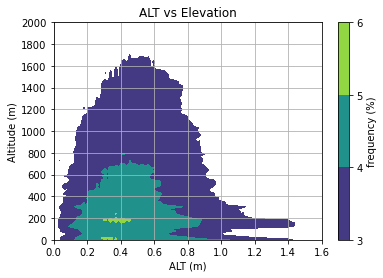

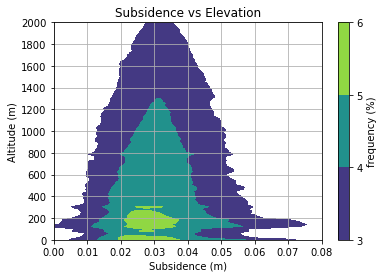

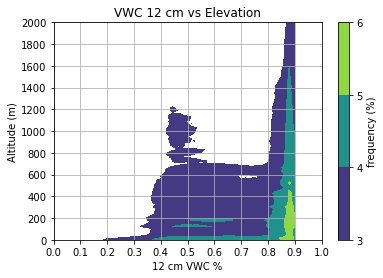

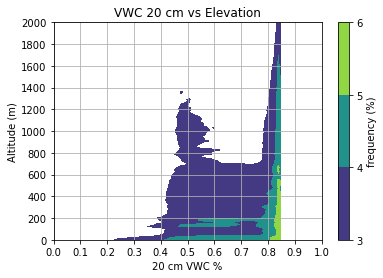

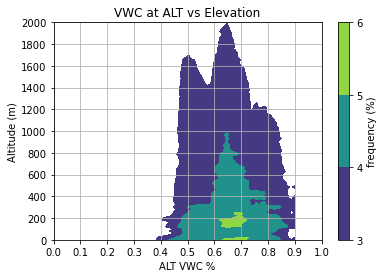

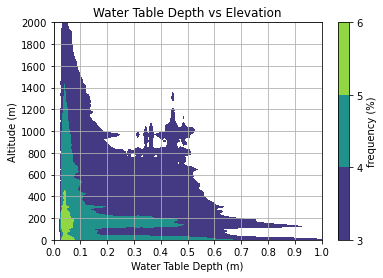

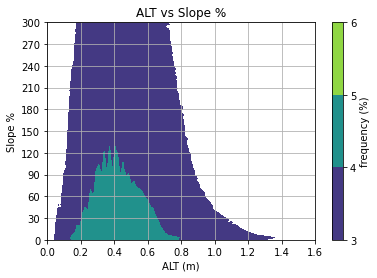

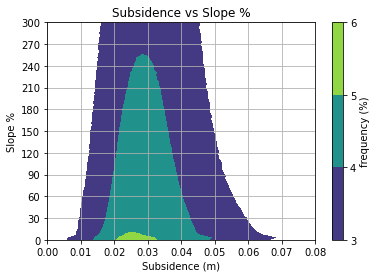

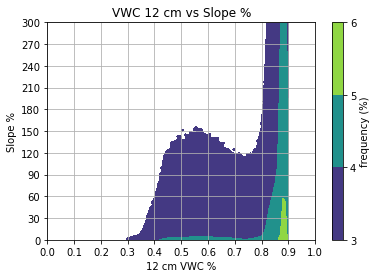

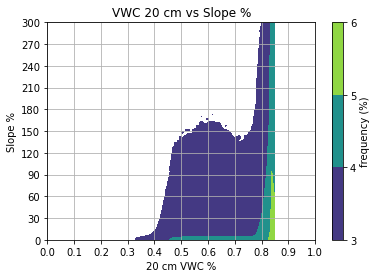

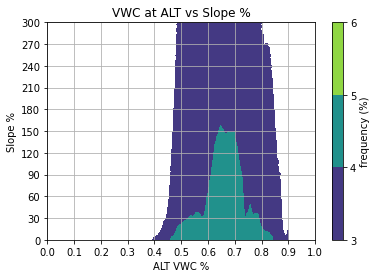

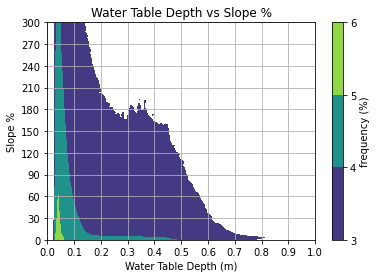

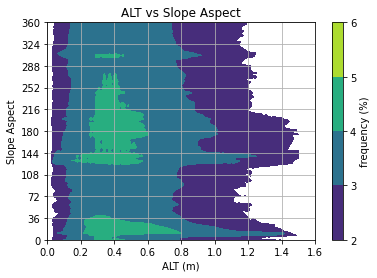

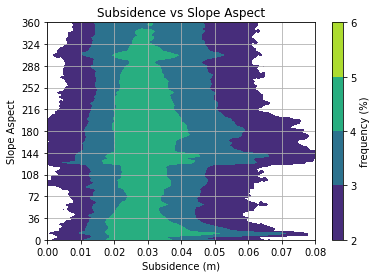

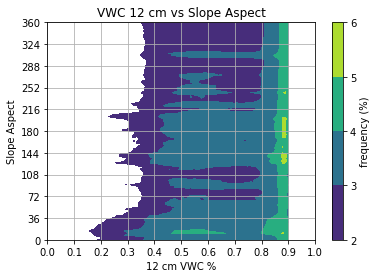

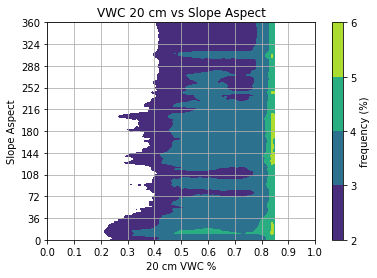

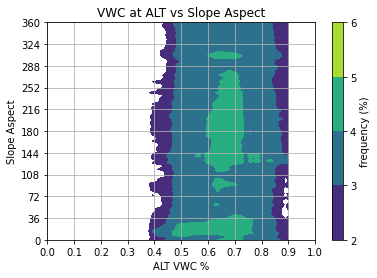

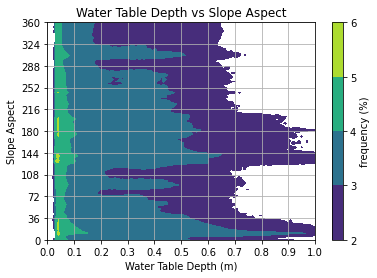

In [28]:
if import_dem:
# PLOTTING STUFF VS ELEVATION FROM DEM
    # PLOTTING ALT VS ELEVATION
    # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_alt_dem)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_masked = np.ma.masked_where(pdf_alt_dem == 0. , pdf_alt_dem)
    pdf_masked = np.log10(pdf_masked, where=np.logical_not(pdf_masked.mask))
    #print(pdf_masked)
    xmin  =0
    xmax  =1.6
    deltax=.2
    ymin  =0
    ymax  =2000
    deltay=200.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='ALT vs Elevation'
    labx="ALT (m)"
    laby="Altitude (m)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_alt_elev_'+swath+'.png'
    plot_contour(alt_pdf, dem_pdf, pdf_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
    # PLOTTING SUBSIDENCE VS ELEVATION
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_sub_dem)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_sub_masked = np.ma.masked_where(pdf_sub_dem == 0. , pdf_sub_dem)
    pdf_sub_masked = np.log10(pdf_sub_masked, where=np.logical_not(pdf_sub_masked.mask))
    #print(pdf_sub_masked)
    xmin  =0
    xmax  =0.08
    deltax=0.01
    ymin  =0
    ymax  =2000
    deltay=200.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='Subsidence vs Elevation'
    labx="Subsidence (m)"
    laby="Altitude (m)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_sub_elev_'+swath+'.png'
    plot_contour(sub_pdf, dem_pdf, pdf_sub_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

     # PLOTTING VWC DOWN TO 12 CM VS ELEVATION
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwc12_dem)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwc12_masked = np.ma.masked_where(pdf_vwc12_dem == 0. , pdf_vwc12_dem)
    pdf_vwc12_masked = np.log10(pdf_vwc12_masked, where=np.logical_not(pdf_vwc12_masked.mask))
    #print(pdf_vwc12_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =2000
    deltay=200.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC 12 cm vs Elevation'
    labx="12 cm VWC %"
    laby="Altitude (m)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwc12_elev_'+swath+'.png'
    plot_contour(vwc_pdf, dem_pdf, pdf_vwc12_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
 # PLOTTING VWC DOWN TO 20 CM VS ELEVATION
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwc20_dem)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwc20_masked = np.ma.masked_where(pdf_vwc20_dem == 0. , pdf_vwc20_dem)
    pdf_vwc20_masked = np.log10(pdf_vwc20_masked, where=np.logical_not(pdf_vwc20_masked.mask))
    #print(pdf_vwc20_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =2000
    deltay=200.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC 20 cm vs Elevation'
    labx="20 cm VWC %"
    laby="Altitude (m)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwc20_elev_'+swath+'.png'
    plot_contour(vwc_pdf, dem_pdf, pdf_vwc20_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    # PLOTTING VWC DOWN TO ALT VS ELEVATION
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwcalt_dem)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwcalt_masked = np.ma.masked_where(pdf_vwcalt_dem == 0. , pdf_vwcalt_dem)
    pdf_vwcalt_masked = np.log10(pdf_vwcalt_masked, where=np.logical_not(pdf_vwcalt_masked.mask))
    #print(pdf_vwcalt_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =2000
    deltay=200.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC at ALT vs Elevation'
    labx="ALT VWC %"
    laby="Altitude (m)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwcalt_elev_'+swath+'.png'
    plot_contour(vwc_pdf, dem_pdf, pdf_vwcalt_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    # PLOTTING WATER TABLE DEPTH VS ELEVATION
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_wtd_dem)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_wtd_masked = np.ma.masked_where(pdf_wtd_dem == 0. , pdf_wtd_dem)
    pdf_wtd_masked = np.log10(pdf_wtd_masked, where=np.logical_not(pdf_wtd_masked.mask))
    #print(pdf_wtd_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =2000
    deltay=200.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='Water Table Depth vs Elevation'
    labx="Water Table Depth (m)"
    laby="Altitude (m)"
    labcon='frequency (%)'
    filename= out_path + 'pdf_wtd_elev_'+swath+'.png'
    plot_contour(wtd_pdf, dem_pdf, pdf_wtd_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
    
# PLOTTING STUFF VERSUS SLOPE PERCENTAGE
    # PLOTTING ALT VS SLOPE
    # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_alt_slo)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_alt_slo_masked = np.ma.masked_where(pdf_alt_slo == 0. , pdf_alt_slo)
    pdf_alt_slo_masked = np.log10(pdf_alt_slo_masked, where=np.logical_not(pdf_alt_slo_masked.mask))
    #print(pdf_masked)
    xmin  =0
    xmax  =1.6
    deltax=.2
    ymin  =0
    ymax  =300
    deltay=30.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='ALT vs Slope %'
    labx="ALT (m)"
    laby="Slope %"
    labcon='frequency (%)'
    filename= out_path + 'pdf_alt_slope_'+swath+'.png'
    plot_contour(alt_pdf, slo_pdf, pdf_alt_slo_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
    # PLOTTING SUBSIDENCE VS SLOPE
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_sub_slo)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_sub_slo_masked = np.ma.masked_where(pdf_sub_slo == 0. , pdf_sub_slo)
    pdf_sub_slo_masked = np.log10(pdf_sub_slo_masked, where=np.logical_not(pdf_sub_slo_masked.mask))
    #print(pdf_sub_masked)
    xmin  =0
    xmax  =0.08
    deltax=0.01
    ymin  =0
    ymax  =300
    deltay=30.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='Subsidence vs Slope %'
    labx="Subsidence (m)"
    laby="Slope %"
    labcon='frequency (%)'
    filename= out_path + 'pdf_sub_slope_'+swath+'.png'
    plot_contour(sub_pdf, slo_pdf, pdf_sub_slo_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

     # PLOTTING VWC DOWN TO 12 CM VS SLOPE PERCENTAGE
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwc12_slo)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwc12_slo_masked = np.ma.masked_where(pdf_vwc12_slo == 0. , pdf_vwc12_slo)
    pdf_vwc12_slo_masked = np.log10(pdf_vwc12_slo_masked, where=np.logical_not(pdf_vwc12_slo_masked.mask))
    #print(pdf_vwc12_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =300
    deltay=30.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC 12 cm vs Slope %'
    labx="12 cm VWC %"
    laby="Slope %"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwc12_slope_'+swath+'.png'
    plot_contour(vwc_pdf, slo_pdf, pdf_vwc12_slo_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
 # PLOTTING VWC DOWN TO 20 CM VS SLOPE PERCENTAGE
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwc20_slo)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwc20_slo_masked = np.ma.masked_where(pdf_vwc20_slo == 0. , pdf_vwc20_slo)
    pdf_vwc20_slo_masked = np.log10(pdf_vwc20_slo_masked, where=np.logical_not(pdf_vwc20_slo_masked.mask))
    #print(pdf_vwc20_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =300
    deltay=30.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC 20 cm vs Slope %'
    labx="20 cm VWC %"
    laby="Slope %"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwc20_slope_'+swath+'.png'
    plot_contour(vwc_pdf, slo_pdf, pdf_vwc20_slo_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    # PLOTTING VWC DOWN TO ALT VS SLOPE PERCENTAGE
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwcalt_slo)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwcalt_slo_masked = np.ma.masked_where(pdf_vwcalt_slo == 0. , pdf_vwcalt_slo)
    pdf_vwcalt_slo_masked = np.log10(pdf_vwcalt_slo_masked, where=np.logical_not(pdf_vwcalt_slo_masked.mask))
    #print(pdf_vwcalt_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =300
    deltay=30.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC at ALT vs Slope %'
    labx="ALT VWC %"
    laby="Slope %"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwcalt_slope_'+swath+'.png'
    plot_contour(vwc_pdf, slo_pdf, pdf_vwcalt_slo_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    # PLOTTING WATER TABLE DEPTH VS SLOPE PERCENTAGE
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_wtd_slo)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_wtd_slo_masked = np.ma.masked_where(pdf_wtd_slo == 0. , pdf_wtd_slo)
    pdf_wtd_slo_masked = np.log10(pdf_wtd_slo_masked, where=np.logical_not(pdf_wtd_slo_masked.mask))
    #print(pdf_wtd_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =300
    deltay=30.
    cmin = 3
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='Water Table Depth vs Slope %'
    labx="Water Table Depth (m)"
    laby="Slope %"
    labcon='frequency (%)'
    filename= out_path + 'pdf_wtd_slope_'+swath+'.png'
    plot_contour(wtd_pdf, slo_pdf, pdf_wtd_slo_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
# PLOTTING STUFF VERSUS SLOPE ASPECT
    # PLOTTING ALT VS SLOPE ASPECT
    # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_alt_asp)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_alt_asp_masked = np.ma.masked_where(pdf_alt_asp == 0. , pdf_alt_asp)
    pdf_alt_asp_masked = np.log10(pdf_alt_asp_masked, where=np.logical_not(pdf_alt_asp_masked.mask))
    #print(pdf_masked)
    xmin  =0
    xmax  =1.6
    deltax=.2
    ymin  =0
    ymax  =360
    deltay=36.
    cmin = 2
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='ALT vs Slope Aspect'
    labx="ALT (m)"
    laby="Slope Aspect"
    labcon='frequency (%)'
    filename= out_path + 'pdf_alt_slope_aspect_'+swath+'.png'
    plot_contour(alt_pdf, asp_pdf, pdf_alt_asp_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
    # PLOTTING SUBSIDENCE VS SLOPE ASPECT
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_sub_asp)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_sub_asp_masked = np.ma.masked_where(pdf_sub_asp == 0. , pdf_sub_asp)
    pdf_sub_asp_masked = np.log10(pdf_sub_asp_masked, where=np.logical_not(pdf_sub_asp_masked.mask))
    #print(pdf_sub_masked)
    xmin  =0
    xmax  =0.08
    deltax=0.01
    ymin  =0
    ymax  =360
    deltay=36.
    cmin = 2
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='Subsidence vs Slope Aspect'
    labx="Subsidence (m)"
    laby="Slope Aspect"
    labcon='frequency (%)'
    filename= out_path + 'pdf_sub_slope_aspect_'+swath+'.png'
    plot_contour(sub_pdf, asp_pdf, pdf_sub_asp_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

     # PLOTTING VWC DOWN TO 12 CM VS SLOPE ASPECT
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwc12_asp)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwc12_asp_masked = np.ma.masked_where(pdf_vwc12_asp == 0. , pdf_vwc12_asp)
    pdf_vwc12_asp_masked = np.log10(pdf_vwc12_asp_masked, where=np.logical_not(pdf_vwc12_asp_masked.mask))
    #print(pdf_vwc12_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =360
    deltay=36.
    cmin = 2
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC 12 cm vs Slope Aspect'
    labx="12 cm VWC %"
    laby="Slope Aspect"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwc12_slope_aspect_'+swath+'.png'
    plot_contour(vwc_pdf, asp_pdf, pdf_vwc12_asp_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    
 # PLOTTING VWC DOWN TO 20 CM VS SLOPE ASPECT
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwc20_asp)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwc20_asp_masked = np.ma.masked_where(pdf_vwc20_asp == 0. , pdf_vwc20_asp)
    pdf_vwc20_asp_masked = np.log10(pdf_vwc20_asp_masked, where=np.logical_not(pdf_vwc20_asp_masked.mask))
    #print(pdf_vwc20_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =360
    deltay=36.
    cmin = 2
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC 20 cm vs Slope Aspect'
    labx="20 cm VWC %"
    laby="Slope Aspect"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwc20_slope_aspect_'+swath+'.png'
    plot_contour(vwc_pdf, asp_pdf, pdf_vwc20_asp_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    # PLOTTING VWC DOWN TO ALT VS ASPECT
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_vwcalt_asp)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_vwcalt_asp_masked = np.ma.masked_where(pdf_vwcalt_asp == 0. , pdf_vwcalt_asp)
    pdf_vwcalt_asp_masked = np.log10(pdf_vwcalt_asp_masked, where=np.logical_not(pdf_vwcalt_asp_masked.mask))
    #print(pdf_vwcalt_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =360
    deltay=36.
    cmin = 2
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='VWC at ALT vs Slope Aspect'
    labx="ALT VWC %"
    laby="Slope Aspect"
    labcon='frequency (%)'
    filename= out_path + 'pdf_vwcalt_slope_aspect_'+swath+'.png'
    plot_contour(vwc_pdf, asp_pdf, pdf_vwcalt_asp_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)

    # PLOTTING WATER TABLE DEPTH VS SLOPE ASPECT
        # alt_pdf, lat_pdf, pdf_alt_lat
    total = np.sum(pdf_wtd_asp)
   # pdf_alt_dem = pdf_alt_dem*total/100
    pdf_wtd_asp_masked = np.ma.masked_where(pdf_wtd_asp == 0. , pdf_wtd_asp)
    pdf_wtd_asp_masked = np.log10(pdf_wtd_asp_masked, where=np.logical_not(pdf_wtd_asp_masked.mask))
    #print(pdf_wtd_masked)
    xmin  =0
    xmax  =1
    deltax=1/10
    ymin  =0
    ymax  =360
    deltay=36.
    cmin = 2
    cmax = 6 #np.max(pdf_alt_dem)
    deltac =1
    title='Water Table Depth vs Slope Aspect'
    labx="Water Table Depth (m)"
    laby="Slope Aspect"
    labcon='frequency (%)'
    filename= out_path + 'pdf_wtd_slope_aspect_'+swath+'.png'
    plot_contour(wtd_pdf, asp_pdf, pdf_wtd_asp_masked, xmin,xmax, deltax, ymin,ymax, deltay,cmin, cmax, deltac,labx, laby, labcon, title, filename)


In [6]:
np.save('preliminary_dem_alt_numpy_array.npy',pdf_alt_dem)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0640977


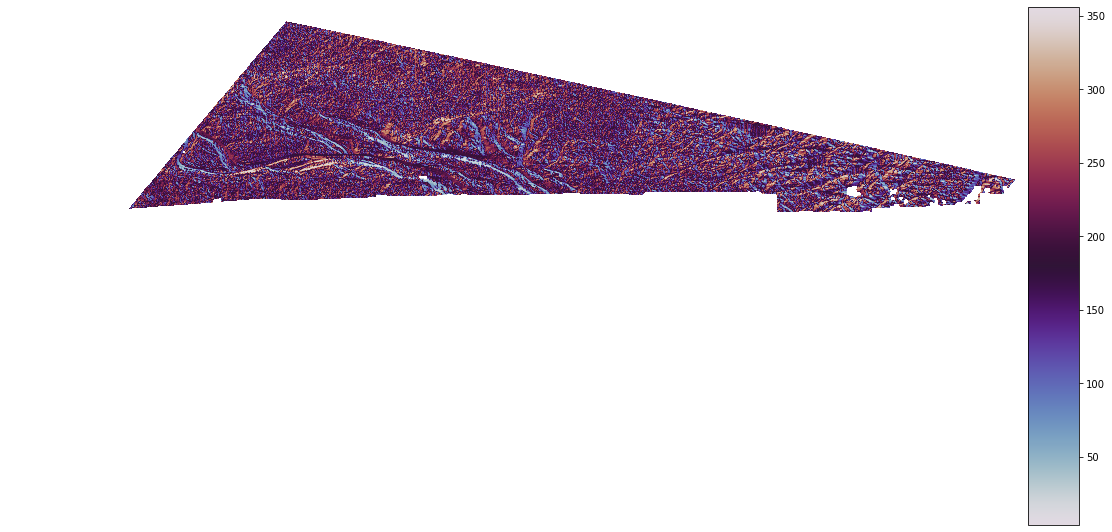

{'vmin': 3.743110108375549, 'vmax': 356.25764404296876}

In [99]:
# some testing of richDEM python package

slope_aspect_ex = rd.TerrainAttribute(rda, attrib='aspect') 
# possible attributes: aspect, slope_riserun, slope_percentage,slope_degrees, profile_curvature, planform_curvature
rd.rdShow(slope_aspect_ex,axes=False,cmap='twilight',figsize=(16,7.5))

In [31]:
filename=V3_path+file_list[ifile]
temp = file_list[ifile]
swath=temp[11:17]
nscan, nspot, alt, sub, vwc_12, vwc_20, vwc_alt, wtd, lon, lat, has_vwc = read_pdo_version_3_netcdf_file(filename, print_flag)
# nscan = number of points in range or x, nspot = number of points in azimuth or y

if import_dem:
# IMPORT ArcticDEM
    dem_filename = V3_path+temp[0:25]+'_qa_exent_ArcticDEM_mosaic_crop_prj.tif'
    dem_file = rasterio.open(dem_filename)
    dem_data = dem_file.read(1)

    rda = rd.rdarray(dem_data, no_data = -9999)
    slope = rd.TerrainAttribute(rda, attrib='slope_percentage')
    aspect = rd.TerrainAttribute(rda, attrib='aspect')


    #rd.rdShow(slope,axes=False,cmap='turbo',figsize=(8,5.5))
    toplat = dem_file.bounds.top
    botlat = dem_file.bounds.bottom
    leflon = dem_file.bounds.left
    riglon = dem_file.bounds.right
    demsize = np.shape(dem_data)

    #print(filename, toplat, botlat, leflon, riglon)
    dem_lat = np.linspace(botlat, toplat, demsize[0])
    dem_lon = np.linspace(leflon, riglon,demsize[1])        
    #plt.imshow(dem_data)

    # Use scipy.interpolate.RegularGridInterpolator to interpolate the DEM values onto the PDO coordinates: 
    # This also allows you to change the DEM interpolation method to/from linear and nearest5e
    dem_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),dem_data,method='linear',bounds_error=False,fill_value = -9999)
    dem_resampled = dem_interpolant((lat,lon))
    demvec = dem_resampled

    slo_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),slope,method='linear',bounds_error=False,fill_value = -9999)
    slo_resampled = slo_interpolant((lat,lon))
    slovec = slo_resampled

    asp_interpolant = scipy.interpolate.RegularGridInterpolator((dem_lat,dem_lon),aspect,method='linear',bounds_error=False,fill_value = -9999)
    asp_resampled = dem_interpolant((lat,lon))
    aspvec = asp_resampled

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (percenage)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0369539

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0614152


In [33]:
print(demvec.shape)
print(alt.shape)

(3699108,)
(3699108,)


In [71]:
missing_alt = alt == -9999
missing_sub = sub == -9999
missing_demvec = demvec == -9999
missing_slovec = slovec == -9999
missing_aspvec = aspvec == -9999

In [72]:
missing_array = np.array([missing_alt, missing_sub, missing_demvec, missing_slovec, missing_aspvec]).T

In [67]:
print(len(filtered_alt[1]))

596907


In [101]:
pca_array = np.array([alt, sub, demvec, slovec, aspvec]).T
print(min(alt))
print(max(alt))
print(min(sub))
print(max(sub))
print(min(demvec))
print(max(demvec))
print(min(slovec))
print(max(slovec))
print(min(aspvec))
print(max(aspvec))

-9999.0
1.4398333
-9999.0
0.0732174
-9999.000000000004
234.96917002895725
-9999.000000000004
2153.6190323819155
-9999.000000000004
234.96917002895725


(array([3102201.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  596907.]),
 array([-9.9990000e+03, -8.9989561e+03, -7.9989121e+03, -6.9988682e+03,
        -5.9988242e+03, -4.9987803e+03, -3.9987361e+03, -2.9986921e+03,
        -1.9986482e+03, -9.9860413e+02,  1.4398333e+00], dtype=float32),
 <BarContainer object of 10 artists>)

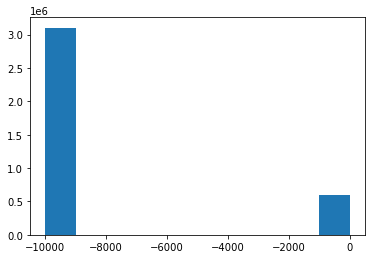

In [108]:
plt.hist(alt)

In [98]:
print(pca_array.shape)

(3699108, 5)


In [123]:
print(max(lon))
print(min(lon))

-111.20504735595632
-112.27788874971802


In [124]:
pca_array = np.array([lon, lat, alt, sub, demvec, slovec, aspvec]).T
rows_to_keep = []
for row_index in range(len(missing_array)):
    if np.all(pca_array[row_index]>-130):
        rows_to_keep.append(row_index)
pca_array = pca_array[rows_to_keep]

In [113]:
print(min(pca_array[0]))
print(max(pca_array[0]))
print(min(pca_array[1]))
print(max(pca_array[1]))
print(min(pca_array[2]))
print(max(pca_array[2]))
print(min(pca_array[3]))
print(max(pca_array[3]))
print(min(pca_array[4]))
print(max(pca_array[4]))

0.042819902300834656
337.95904750983476
0.04276690259575844
173.10266620110195
0.04749084636569023
172.29419901313275
-8.190998228231082
106.57760189575725
0.048741430044174194
307.5401054309282


In [114]:
print(pca_array.shape)

(141287, 5)


In [115]:
n_pcs = 2
pca = PCA(n_components=n_pcs)
pca.fit(pca_array[:,2:])
pca_out_array = pca.transform(pca_array[:,2:])

In [116]:
print(pca_out_array.shape)

(141287, 2)


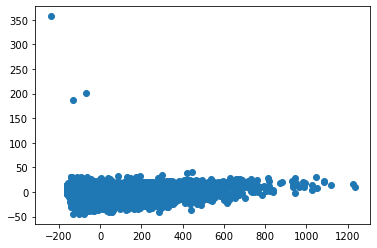

In [117]:
plt.scatter(pca_out_array[::10,0], pca_out_array[::10,1])

In [125]:
kmeans = KMeans(n_clusters=2, random_state=10).fit(pca_array[:,2:])
kmeans_label = kmeans.labels_

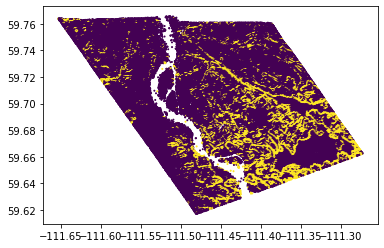

In [132]:
plt.scatter(pca_array[:,0], pca_array[:,1], c=kmeans_label, s=1)

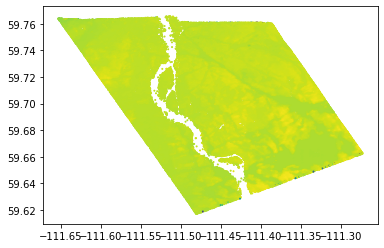

In [134]:
plt.scatter(pca_array[:,0], pca_array[:,1], c=pca_array[:,4], s=1)